In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions
import rawdata
import inputstate
import coincidencecheck
import scissor
import qutip

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
## Simulation parameters

dimension = 5
single_photon_efficiency = 0.4
alice_transmission = 0.237*0.92
bob_transmission = 0.168*0.92
hd_eff = 0.7

# Extra functions

In [3]:
def plot_time_window(rho, input_data, fidelity, success_rate, window_list, voltages, simulations = True):
    input_alpha = [input_data[v].input_alpha for v in voltages]#[np.trace(functions.a_operator(n_dim)@input_data[v].input_rho) for v in voltages]
    sim_fidelity = {v: None for v in voltages}
    sim_success_rate = {v: None for v in voltages}
    sim_purity = {v: None for v in voltages}
    
    rho_vac = np.zeros((n_dim+1, n_dim+1))
    rho_vac[0][0] = 1
    fid_vac = [functions.quantumStateFidelity(rho_vac, input_data[v].input_rho) for v in voltages]
    
    if simulations:
        for j, v in enumerate(voltages):
            sim_fidelity[v], sim_success_rate[v], sim_purity[v] = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7)
#             _, sim_success_rate[v], sim_purity[v], out_rho = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7, output = True)
#             sim_fidelity[v] = scissor.quantum_fidelity(qutip.coherent_dm(dimension, input_alpha[j]*np.exp(1j*np.pi)), out_rho)
        sim_fidsuc = [sim_fidelity[v]*sim_success_rate[v] for v in voltages]
    
    colors = ['blue', 'orange', 'green']
    # Fidelity
    plt.figure()
    for j, v in enumerate(voltages):
        plt.axhline(fid_vac[j], color = colors[j], linestyle = ':')
        plt.scatter(window_list, fidelity[v], color = colors[j], label = 'Data '+ v)
        if simulations:
            plt.axhline(sim_fidelity[v], color = colors[j], linestyle = '--')
        plt.legend()
        plt.title('Fidelity vs time window')
        plt.xlabel('Time windows (ns)')
        plt.ylabel('Fidelity')
    plt.grid()
    plt.show()

    # Success rate
    plt.figure()
    for j, v in enumerate(voltages):
        prob = [100*s for s in success_rate[v]]
        plt.scatter(window_list, prob, color = colors[j], label = 'Data '+ v)
        if simulations:
            plt.axhline(100*sim_success_rate[v], color = colors[j], linestyle = '--')
        plt.legend()
        plt.title('Success rate vs time window')
        plt.xlabel('Time windows (ns)')
        plt.ylabel('Success_rate (%)')
    plt.grid()
    plt.show()

    # Fidelity times success rate
    fid_success = {v: None for v in voltages}
    plt.figure()
    for j, v in enumerate(voltages):
        fid_success[v] = [fidelity[v][j]*success_rate[v][j] for j in range(len(fidelity[v]))]
        plt.scatter(window_list, fid_success[v], color = colors[j], label = 'Data '+ v)
        if simulations:
            plt.axhline(sim_fidsuc[j], color = colors[j], linestyle = '--')
        plt.legend()
        plt.title('Fidelity * success rate vs time window')
        plt.xlabel('Time windows (ns)')
        plt.ylabel('Fidelity * success rate')
    plt.grid()
    plt.show()

    # Purity
    purity = {v: np.zeros((len(window_list)), dtype = complex) for v in voltages}
    for v in voltages:
        for t in range(len(window_list)):
            purity[v][t] = np.abs(np.trace(rho[v][t]@rho[v][t]))
    plt.figure()
    for j, v in enumerate(voltages):
        plt.scatter(window_list, purity[v], color = colors[j], label = 'Data '+ v)
        if simulations:
            plt.axhline(sim_purity[v], color = colors[j], linestyle = '--')
        plt.legend()
        plt.title('Purity vs time window')
        plt.xlabel('Time windows (ns)')
        plt.ylabel('Purity of output state')
    plt.grid()
    plt.show()

    fid_success_array = np.zeros((len(voltages), len(window_list)), dtype = complex)
    for n, v in enumerate(voltages):
        fid_success_array[n][:] = fid_success[v][:]

    # Fidelity times success rate across each data
    plt.figure()
    for n, t in enumerate(window_list):
        plt.scatter(input_alpha, fid_success_array[:,n], label = f"Time window {t:.2g}")
        if simulations:
            plt.plot(input_alpha, sim_fidsuc, linestyle = '--')
        plt.legend(loc = 'center right', bbox_to_anchor = (1.4,.5))
        plt.title('Fidelity * success rate')
        plt.xlabel('Input alpha')
        plt.ylabel('Fidelity * success rate')
    plt.grid()
    plt.show()
    
def plot_mf_parameters(rho, input_data, fidelity, success_rate, mf_list, voltages, simulations = True):
    input_alpha = [input_data[v][0].input_alpha for v in voltages]#[np.abs(np.trace(functions.a_operator(n_dim)@input_data[v][0].input_rho)) for v in voltages]
    sim_fidelity = {v: None for v in voltages}
    sim_success_rate = {v: None for v in voltages}
    sim_purity = {v: None for v in voltages}
    
    rho_vac = np.zeros((n_dim+1, n_dim+1))
    rho_vac[0][0] = 1
    fid_vac = [functions.quantumStateFidelity(rho_vac, input_data[v][0].input_rho) for v in voltages]

    if simulations:
        for j, v in enumerate(voltages):
            sim_fidelity[v], sim_success_rate[v], sim_purity[v] = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7)
#             _, sim_success_rate[v], sim_purity[v], out_rho = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7, output = True)
#             sim_fidelity[v] = scissor.quantum_fidelity(qutip.coherent_dm(dimension, input_alpha[j]*np.exp(1j*np.pi)), out_rho)
    sim_fidsuc = [sim_fidelity[v]*sim_success_rate[v] for v in voltages]

    colors = ['blue', 'orange', 'green']
    # Fidelity
    plt.figure()
    for j, v in enumerate(voltages):
        plt.axhline(fid_vac[j], color = colors[j], linestyle = ':')
        plt.scatter(mf_list, fidelity[v], color = colors[j], label = 'Data '+ v)
        if simulations:
            plt.axhline(sim_fidelity[v], color = colors[j], linestyle = '--')
        plt.legend()
        plt.title('Fidelity vs time window')
        plt.xlabel('Time windows (ns)')
        plt.ylabel('Fidelity')
    plt.grid()
    plt.show()

    # Success rate
    # plt.figure()
    # for j, v in enumerate(voltages):
    #     prob = [100*s for s in success_rate[v]]
    #     plt.scatter(g_list, prob, color = colors[j], label = 'Data '+ v)
    #     if simulations:
    #         plt.axhline(100*sim_success_rate[v], color = colors[j], linestyle = '--')
    #     plt.legend()
    #     plt.title('Success rate vs time window')
    #     plt.xlabel('Time windows (ns)')
    #     plt.ylabel('Success_rate (%)')
    # plt.grid()
    # plt.show()

    # Fidelity times success rate
    fid_success = {v: None for v in voltages}
    plt.figure()
    for j, v in enumerate(voltages):
        fid_success[v] = [fidelity[v][j]*success_rate[v] for j in range(len(fidelity[v]))]
        plt.scatter(mf_list, fid_success[v], color = colors[j], label = 'Data '+ v)
        if simulations:
            plt.axhline(sim_fidsuc[j], color = colors[j], linestyle = '--')
        plt.legend()
        plt.title('Fidelity * success rate vs time window')
        plt.xlabel('Time windows (ns)')
        plt.ylabel('Fidelity * success rate')
    plt.grid()
    plt.show()

    # Purity
    purity = {v: np.zeros((len(mf_list)), dtype = complex) for v in voltages}
    for v in voltages:
        for g in range(len(mf_list)):
            purity[v][g] = np.abs(np.trace(rho[v][g]@rho[v][g]))
    plt.figure()
    for j, v in enumerate(voltages):
        plt.scatter(mf_list, purity[v], color = colors[j], label = 'Data '+ v)
        if simulations:
            plt.axhline(sim_purity[v], color = colors[j], linestyle = '--')
        plt.legend()
        plt.title('Purity vs time window')
        plt.xlabel('Time windows (ns)')
        plt.ylabel('Purity of output state')
    plt.grid()
    plt.show()

    fid_success_array = np.zeros((len(voltages), len(mf_list)), dtype = complex)
    for n, v in enumerate(voltages):
        fid_success_array[n][:] = fid_success[v][:]

    # Fidelity times success rate across each data
    # plt.figure()
    # for n, t in enumerate(window_list):
    #     plt.scatter(input_alpha, fid_success_array[:,n], label = f"Time window {t:.2g}")
    #     if simulations:
    #         plt.plot(input_alpha, sim_fidsuc, linestyle = '--')
    #     plt.legend(loc = 'center right', bbox_to_anchor = (1.4,.5))
    #     plt.title('Fidelity * success rate')
    #     plt.xlabel('Input alpha')
    #     plt.ylabel('Fidelity * success rate')
    # plt.grid()
    # plt.show()

# Import data

Data imported
Clearance at 10.0 MHz is 15.74 dB
6 files for each phase
10000 sequences on each file with 252 data points each
Data imported
Clearance at 10.0 MHz is 15.75 dB
6 files for each phase
10000 sequences on each file with 252 data points each
Data imported
Clearance at 10.0 MHz is 14.92 dB
5 files for each phase
10000 sequences on each file with 252 data points each


"\n# Time information\nsequences = meta['subarray_count']\n#files_for_each_phase = int(len(homodyne['000'])/sequences)\n#total_sequences = files_for_each_phase*sequences\ntotal_points = meta['wave_array_count']\npoints_per_seq = int(meta['wave_array_count']/sequences)\nTs = meta['horiz_interval']\nbegin = meta['horiz_offset']\nx = np.linspace(begin, begin + Ts*total_points, total_points)\nx_sequence = np.linspace(begin, begin + Ts*points_per_seq, points_per_seq)\n#print('%d files for each phase' %files_for_each_phase)\n#print('%d sequences on each file with %d data points each' %(sequences, points_per_seq))\n"

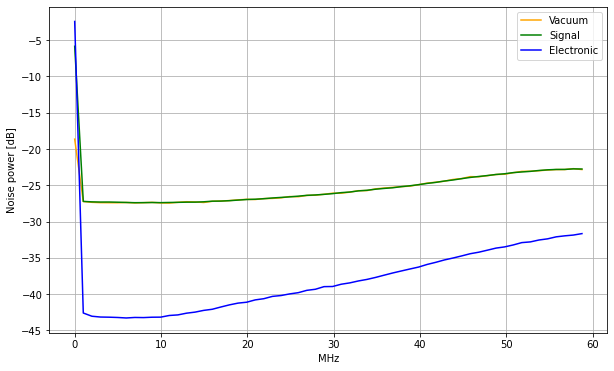

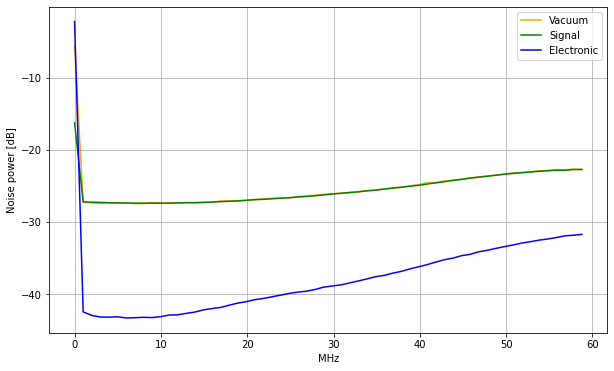

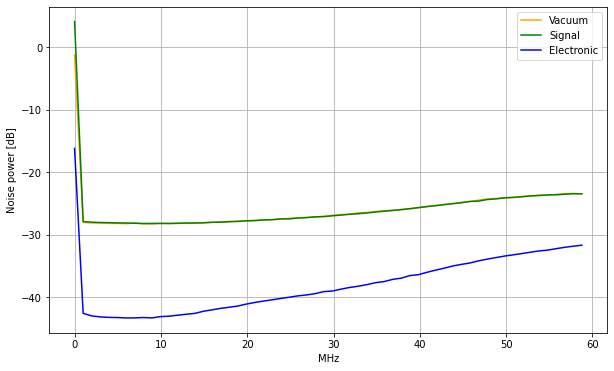

In [4]:
# Tomography information
tomography_phases = ['000', '030', '060', '090', '120', '150']
n_dim = 15 # Dimension for analysis

# Folder with data
'''
folder = "C:/Users/qpitlab/Desktop/Scissor QKD data/teleportation/"
date = "20240213/"
data = ''
extra = 'size0-phase0/'
path = folder + date + data + extra
homodyne, heralding, charlie, vacuum, meta = import_data(path)
'''
# Import multiple data
voltages = ['vac', '001', '002']
folder = "C:/Users/lunfa/Documents/PhD/Python/teleportation/files/teleportation/"
date = {'vac': '20240213/', '001': '20240213/', '002': '20240209/'}
extra = {'vac': 'size0-phase0/', '001': 'voltage001-phase090/', '002': 'voltage002-phase090/'}
path = {v: folder + date[v] + extra[v] for v in voltages}
data = {v: None for v in voltages}
homodyne = {v: None for v in voltages}
heralding = {v: None for v in voltages}
charlie = {v: None for v in voltages}
vacuum = {v: None for v in voltages}
files_for_each_phase = {v: None for v in voltages}
total_sequences = {v: None for v in voltages}
for v in voltages:
    data[v] = rawdata.rawdata(path[v], n_dim)
    homodyne[v] = data[v].homodyne
    charlie[v] = data[v].charlie
    vacuum[v] = data[v].vacuum
    sequences = data[voltages[0]].sequences
    points_per_seq = data[voltages[0]].points_per_seq
    files_for_each_phase[v] = data[v].files_for_each_phase
    total_sequences[v] = files_for_each_phase[v]*sequences
    print('%d files for each phase' %files_for_each_phase[v])
    print('%d sequences on each file with %d data points each' %(sequences, points_per_seq))
'''
# Time information
sequences = meta['subarray_count']
#files_for_each_phase = int(len(homodyne['000'])/sequences)
#total_sequences = files_for_each_phase*sequences
total_points = meta['wave_array_count']
points_per_seq = int(meta['wave_array_count']/sequences)
Ts = meta['horiz_interval']
begin = meta['horiz_offset']
x = np.linspace(begin, begin + Ts*total_points, total_points)
x_sequence = np.linspace(begin, begin + Ts*points_per_seq, points_per_seq)
#print('%d files for each phase' %files_for_each_phase)
#print('%d sequences on each file with %d data points each' %(sequences, points_per_seq))
'''

# Apply single mode function and analyse input state

VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


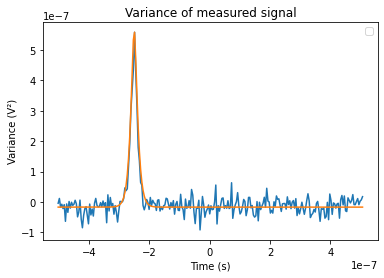

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


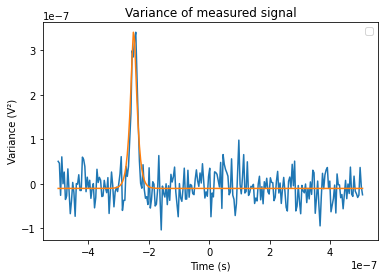

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1245956103497702
Block 1 Input |\alpha| = 0.08728945842394127
Block 2 Input |\alpha| = 0.07279673246767603
Block 3 Input |\alpha| = 0.16860820370545546
Block 4 Input |\alpha| = 0.045000865309918855
Block 5 Input |\alpha| = 0.12754755955589653
Block 6 Input |\alpha| = 0.10245029437672988
Block 7 Input |\alpha| = 0.13927873368607896
Block 8 Input |\alpha| = 0.1634270323025909
Block 9 Input |\alpha| = 0.12285609624709849
Input |\alpha| averaged through all blocks: 0.12 (0.04)
Input angle averaged through all blocks: 87.89 (17.64)°
Input |alpha| = 0.12
Relay theta = 90.00°
Input state theta = 87.89°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


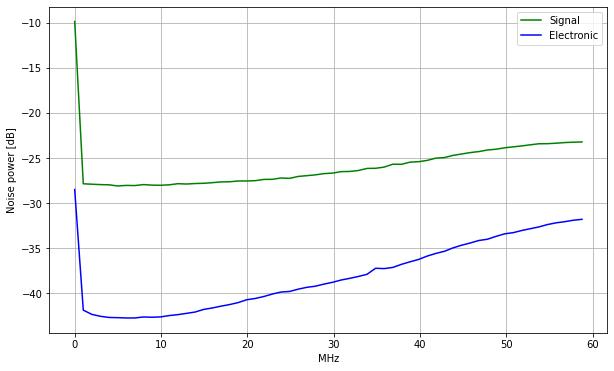

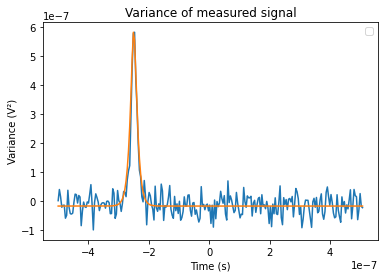

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.17933355489149827
Block 1 Input |\alpha| = 0.2549534275544496
Block 2 Input |\alpha| = 0.23504284067892467
Block 3 Input |\alpha| = 0.22242694760728812
Block 4 Input |\alpha| = 0.21529714645640805
Block 5 Input |\alpha| = 0.2026769620373596
Block 6 Input |\alpha| = 0.2019471160528192
Block 7 Input |\alpha| = 0.21892438061583927
Block 8 Input |\alpha| = 0.29117526412848815
Block 9 Input |\alpha| = 0.25267092000786795
Input |\alpha| averaged through all blocks: 0.23 (0.03)
Input angle averaged through all blocks: 159.32 (6.97)°
Input |alpha| = 0.23
Relay theta = 90.00°
Input state theta = 159.32°
PLOTS FOR INPUT STATE
Success rate = 0.24 %
Success rate = 0.35 %
Success rate = 0.44 %
Success rate = 0.58 %
Success rate = 0.63 %
Success rate = 0.67 %
Success rate = 0.75 %
Success rate = 0.78 %
Success rate = 0.30 

<ipython-input-5-81c0618221ff>:64: ComplexWarning: Casting complex values to real discards the imaginary part
  rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v].input_rho, success_rate[v][i], n_dim, plot = False, verbose = False)


Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
161 runs
|alpha| = 0.01
theta = 83.90°
Converged
122 runs
|alpha| = 0.01
theta = -38.06°
Converged
115 runs
|alpha| = 0.01
theta = -77.10°
Converged
136 runs
|alpha| = 0.01
theta = 68.59°
Converged
158 runs
|alpha| = 0.01
theta = 68.83°
Converged
152 runs
|alpha| = 0.01
theta = 57.64°
Converged
104 runs
|alpha| = 0.08
theta = 32.76°
Converged
154 runs
|alpha| = 0.08
theta = 10.08°
Converged
99 runs
|alpha| = 0.09
theta = 10.29°
Converged
88 runs
|alpha| = 0.10
theta = 3.59°
Converged
85 runs
|alpha| = 0.10
theta = 5.74°
Converged
88 runs
|alpha| = 0.10
theta = 2.65°
Converged
94 runs
|alpha| = 0.10
theta = 3.22°
Converged
97 runs
|alpha| = 0.10
theta = 1.69°
Converged
109 runs
|alpha| = 0.06
theta = 71.61°
Converged
141 runs
|alpha| = 0.07
theta = 51.09°
Converged
110 runs
|alpha| = 0.07
theta = 55.38°
Converged
125 runs
|alpha| = 0.07
theta = 45.39°
Converged
133 runs
|alpha| = 0.07
theta = 45.27°
Converged
141 runs
|alpha| =

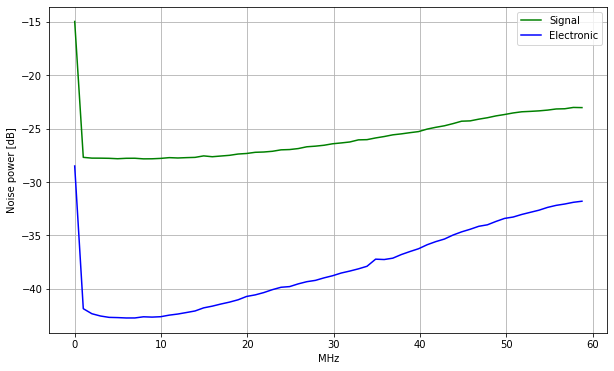

In [5]:
# Input state data
input_data_folder = "20240222/"#"input/"
#voltage_folder = '001/'#extra[extra.find('voltage') + len('voltage'): extra.find('-')]
input_extra = '1/'

input_folder = {'vac': path['vac'], '001': folder + date[v] + input_data_folder + '001/1/', '002': folder + date[v] + input_data_folder + '002/1'}

# Apply temporal mode function to a single data
#mf_homodyne, mf_vacuum, input_rho = apply_mode_function(homodyne, vacuum, input_folder = input_folder, input_plot = False)

# Apply temporal mode function to multilple data
mf_homodyne = {v: None for v in voltages}
mf_vacuum = {v: None for v in voltages}
input_rho = {v: None for v in voltages}
input_data = {v: None for v in voltages}

##### Change mode functions parameters here
for v in voltages:
    mf_homodyne[v], mf_vacuum[v] = data[v].apply_mode_function(homodyne[v], vacuum[v])#, homodyne_time_delay=-317e-9)
    input_data[v] = inputstate.inputstate(input_folder[v], n_dim, data[v].mf, input_plot = False)

    
## Check coincidences    
    
    
# SSPD time delay information
sspd_time_delay = 100e-9
window = 2e-9
window_list = np.linspace(1e-9, 20e-9, 8)

# Obtain data and success rate for a single data and a single time window
#sig, success_rate = teleported_state_with_optimal_success_rate(homodyne, charlie, sspd_time_delay, window)
#sig, success_rate = select_teleported_data(homodyne, charlie, sspd_time_delay - 5e-9, window)

# Obtain data and success rate for a single data and multiple time windows
#vectorize_select = np.vectorize(select_teleported_data)
#sig, success_rate = vectorize_select(homodyne, charlie, sspd_time_delay - 5e-9, window_list)

# Obtain data and success rate for multiple data and multiple time windows
coincidence = {v: [coincidencecheck.selectdata(mf_homodyne[v], charlie[v], data[v].meta, w, verbose = False) for w in window_list] for v in voltages}
sig = {v: [None for w in window_list] for v in voltages}
success_rate = {v: [None for w in window_list] for v in voltages}
for v in voltages:
    for w in range(len(window_list)):
        sig[v][w], success_rate[v][w] = coincidence[v][w].select_teleported_data()
        
        
## Calculate output state


# Calculate output state for single data and multiple time delays
# runs = len(window_list)
# rho = np.zeros((runs, n_dim+1, n_dim+1), dtype = complex)
# fidelity = np.zeros(runs)
# for i in range(runs):
#     rho[i], fidelity[i] = calculate_output_state(sig[i], input_rho, success_rate[i], n_dim, plot = False, verbose = False)

# Calculate output state for multiple data and multiple time delays
runs = len(window_list)
rho = {v: np.zeros((runs, n_dim+1, n_dim+1), dtype = complex) for v in voltages}
fidelity = {v: np.zeros(runs) for v in voltages}
for v in voltages:
    for i in range(runs):
        rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v].input_rho, success_rate[v][i], n_dim, plot = False, verbose = False)

# Calculate fidelity with output state
#fidelity = quantumStateFidelity(rho, input_rho)
#print("Output fidelity is %f" %fidelity)
#print("Success rate is %f" %np.mean(success_rate))
#print("The product of these values is %f" %(fidelity*np.mean(success_rate)))
#print("Purity of output state is %.2f" %np.trace(rho@rho))

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


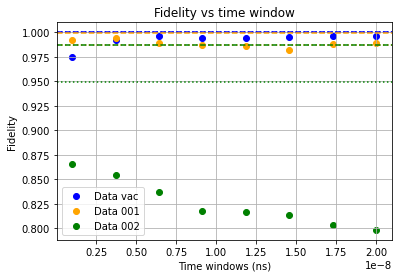

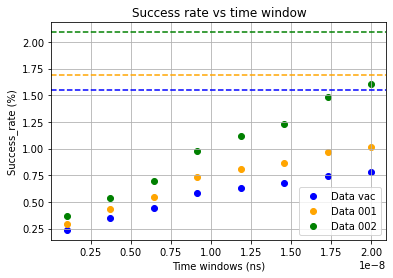

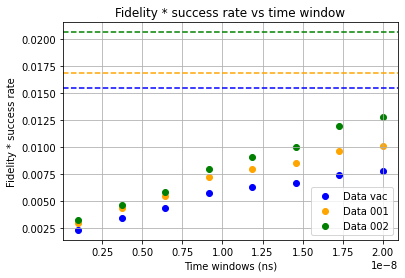

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


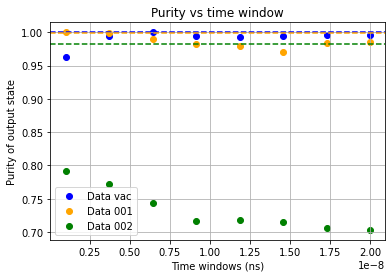

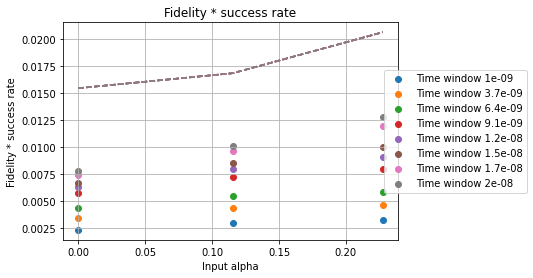

In [6]:
plot_time_window(rho, input_data, fidelity, success_rate, window_list, voltages)

# Comparison between results with/without Charlie click

VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


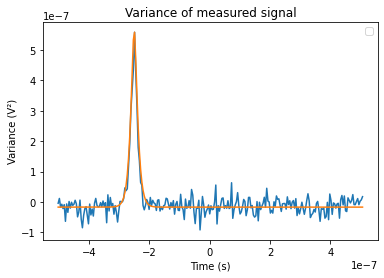

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


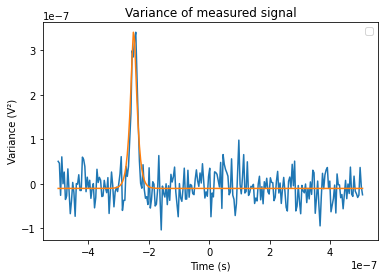

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1245956103497702
Block 1 Input |\alpha| = 0.08728945842394127
Block 2 Input |\alpha| = 0.07279673246767603
Block 3 Input |\alpha| = 0.16860820370545546
Block 4 Input |\alpha| = 0.045000865309918855
Block 5 Input |\alpha| = 0.12754755955589653
Block 6 Input |\alpha| = 0.10245029437672988
Block 7 Input |\alpha| = 0.13927873368607896
Block 8 Input |\alpha| = 0.1634270323025909
Block 9 Input |\alpha| = 0.12285609624709849
Input |\alpha| averaged through all blocks: 0.12 (0.04)
Input angle averaged through all blocks: 87.89 (17.64)°
Input |alpha| = 0.12
Relay theta = 90.00°
Input state theta = 87.89°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


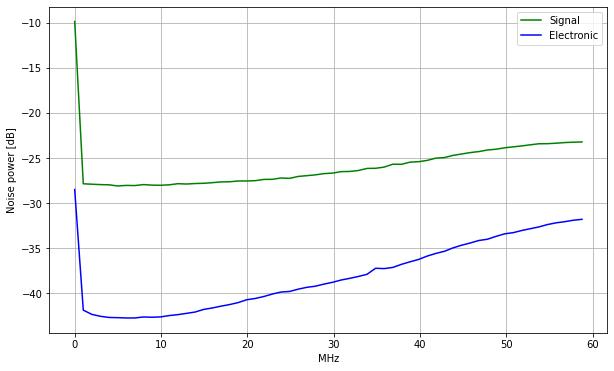

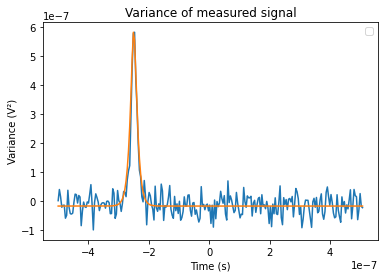

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.17933355489149827
Block 1 Input |\alpha| = 0.2549534275544496
Block 2 Input |\alpha| = 0.23504284067892467
Block 3 Input |\alpha| = 0.22242694760728812
Block 4 Input |\alpha| = 0.21529714645640805
Block 5 Input |\alpha| = 0.2026769620373596
Block 6 Input |\alpha| = 0.2019471160528192
Block 7 Input |\alpha| = 0.21892438061583927
Block 8 Input |\alpha| = 0.29117526412848815
Block 9 Input |\alpha| = 0.25267092000786795
Input |\alpha| averaged through all blocks: 0.23 (0.03)
Input angle averaged through all blocks: 159.32 (6.97)°
Input |alpha| = 0.23
Relay theta = 90.00°
Input state theta = 159.32°
PLOTS FOR INPUT STATE
Success rate = 0.35 %
Success rate = 0.43 %
Success rate = 0.54 %
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
154 runs
|alpha| = 0.08
theta = 10.08°
Converged
141 runs
|alpha| = 0.

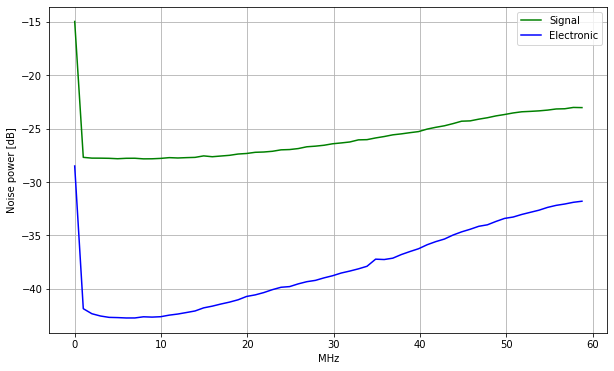

In [7]:
# Input state data
input_data_folder = "20240222/"#"input/"
#voltage_folder = '001/'#extra[extra.find('voltage') + len('voltage'): extra.find('-')]
input_extra = '1/'

input_folder = {'vac': path['vac'], '001': folder + date[v] + input_data_folder + '001/1/', '002': folder + date[v] + input_data_folder + '002/1'}

# Apply temporal mode function to a single data
#mf_homodyne, mf_vacuum, input_rho = apply_mode_function(homodyne, vacuum, input_folder = input_folder, input_plot = False)

# Apply temporal mode function to multilple data
mf_homodyne = {v: None for v in voltages}
mf_vacuum = {v: None for v in voltages}
input_rho = {v: None for v in voltages}
input_data = {v: None for v in voltages}

####### Change mode function parameters here
for v in voltages: 
    mf_homodyne[v], mf_vacuum[v] = data[v].apply_mode_function(homodyne[v], vacuum[v])#, homodyne_time_delay=-317e-9)
    input_data[v] = inputstate.inputstate(input_folder[v], n_dim, data[v].mf, input_plot = False)

## Select data

# Find coincidences    
time_window = 4e-9
coincidence = {v: coincidencecheck.selectdata(mf_homodyne[v], charlie[v], data[v].meta, time_window, verbose = False) for v in voltages}
sig_click = {v: None for v in voltages}
success_rate_click = {v: None for v in voltages}
for v in voltages:
    sig_click[v], success_rate_click[v] = coincidence[v].select_teleported_data()
    
# Consider all click
sig_noclick = mf_homodyne
        
## Calculate output state

# Calculate output state for data with coincidence
rho_click = {v: np.zeros((n_dim+1, n_dim+1), dtype = complex) for v in voltages}
fidelity_click = {v: None for v in voltages}
for v in voltages:
    rho_click[v], fidelity_click[v] = functions.calculate_output_state(sig_click[v], input_data[v].input_rho, success_rate_click, n_dim, plot = False, verbose = False)

# Calculate output state considering all data
rho_noclick = {v: np.zeros((n_dim+1, n_dim+1), dtype = complex) for v in voltages}
fidelity_noclick = {v: None for v in voltages}
for v in voltages:
    rho_noclick[v], fidelity_noclick[v] = functions.calculate_output_state(sig_noclick[v], input_data[v].input_rho, 1, n_dim, plot = False, verbose = False)

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


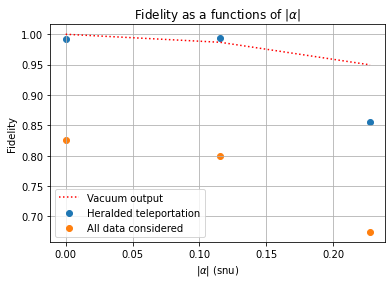

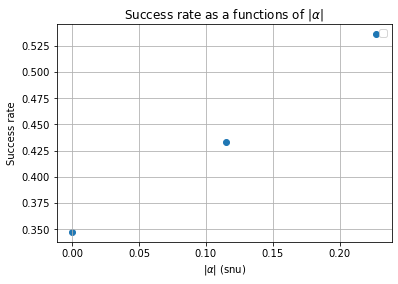

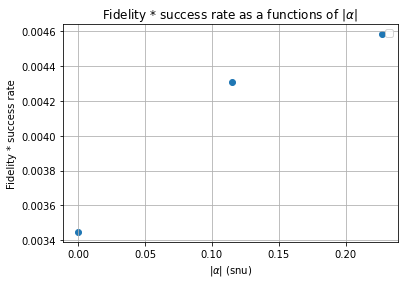

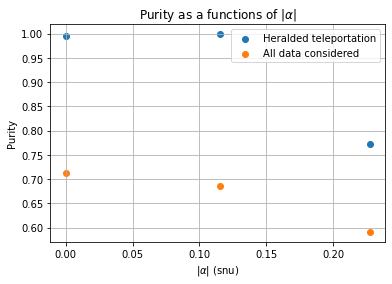

In [9]:
input_alpha = [input_data[v].input_alpha for v in voltages]#[np.abs(np.trace(functions.a_operator(n_dim)@input_data[v].input_rho)) for v in voltages]
fidelity_noclick_list = [fidelity_noclick[v] for v in voltages]
fidelity_click_list = [fidelity_click[v] for v in voltages]

# Fidelity with vacuum
rho_vac = np.zeros((n_dim+1, n_dim+1))
rho_vac[0][0] = 1
fid_vac = [functions.quantumStateFidelity(rho_vac, input_data[v].input_rho) for v in voltages]

snr = [2.25, 107.5, 900]
# Simulated fidelity
sim_fidelity = {v: None for v in voltages}
sim_purity = {v: None for v in voltages}
for j, v in enumerate(voltages):
    sim_fidelity[v], _, sim_purity[v] = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7)
    #_, _, _, out_rho = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7, output = True)
    #sim_fidelity[v] = scissor.quantum_fidelity(qutip.coherent_dm(dimension, input_alpha[j]*np.exp(1j*np.pi)), out_rho)
sim_fidelity_list = [sim_fidelity[v] for v in voltages]

plt.figure()
plt.scatter(input_alpha, fidelity_click_list, label = 'Heralded teleportation')
plt.scatter(input_alpha, fidelity_noclick_list, label = 'All data considered')
plt.plot(input_alpha, fid_vac, label = 'Vacuum output', linestyle = ':', color = 'red')
#plt.plot(input_alpha, sim_fidelity_list, label = 'Simulated result', linestyle = '--', color = 'black')
plt.grid()
plt.legend()
plt.title('Fidelity as a functions of $|\\alpha|$')
plt.ylabel('Fidelity')
plt.xlabel('$|\\alpha|$ (snu)')
plt.show()

prob_click_list = [100*success_rate_click[v] for v in voltages]
plt.figure()
plt.scatter(input_alpha, prob_click_list)
plt.grid()
plt.legend()
plt.title('Success rate as a functions of $|\\alpha|$')
plt.ylabel('Success rate')
plt.xlabel('$|\\alpha|$ (snu)')
plt.show()

fid_prob_click = [fidelity_click_list[j]*prob_click_list[j]/100 for j in range(len(voltages))]
plt.figure()
plt.scatter(input_alpha, fid_prob_click)
plt.grid()
plt.legend()
plt.title('Fidelity * success rate as a functions of $|\\alpha|$')
plt.ylabel('Fidelity * success rate')
plt.xlabel('$|\\alpha|$ (snu)')
plt.show()

purity_click = [np.trace(rho_click[v]@rho_click[v]) for v in voltages]
purity_noclick = [np.trace(rho_noclick[v]@rho_noclick[v]) for v in voltages]
plt.figure()
plt.scatter(input_alpha, purity_click, label = 'Heralded teleportation')
plt.scatter(input_alpha, purity_noclick, label = 'All data considered')
plt.grid()
plt.legend()
plt.title('Purity as a functions of $|\\alpha|$')
plt.ylabel('Purity')
plt.xlabel('$|\\alpha|$ (snu)')
plt.show()

# Varying the angle of the input state

VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


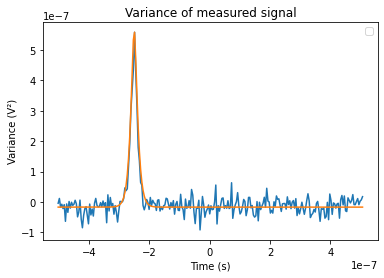

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


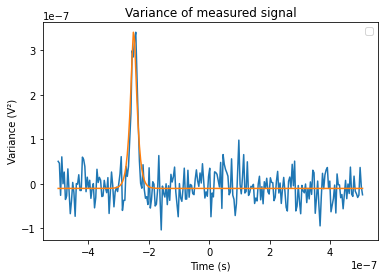

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1245956103497702
Block 1 Input |\alpha| = 0.08728945842394127
Block 2 Input |\alpha| = 0.07279673246767603
Block 3 Input |\alpha| = 0.16860820370545546
Block 4 Input |\alpha| = 0.045000865309918855
Block 5 Input |\alpha| = 0.12754755955589653
Block 6 Input |\alpha| = 0.10245029437672988
Block 7 Input |\alpha| = 0.13927873368607896
Block 8 Input |\alpha| = 0.1634270323025909
Block 9 Input |\alpha| = 0.12285609624709849
Input |\alpha| averaged through all blocks: 0.12 (0.04)
Input angle averaged through all blocks: 87.89 (17.64)°
Input |alpha| = 0.14
Relay theta = 90.00°
Input state theta = 87.89°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


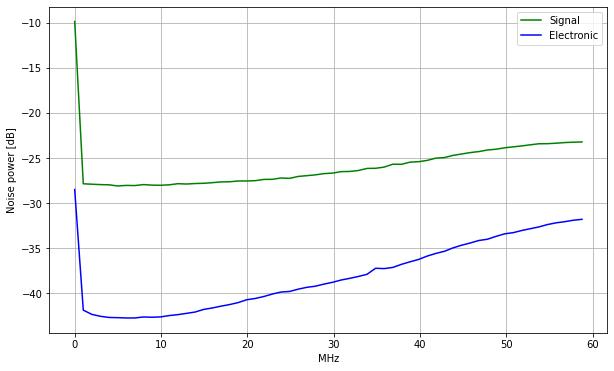

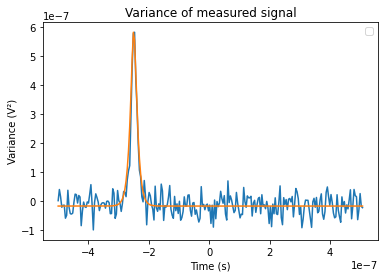

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.17933355489149827
Block 1 Input |\alpha| = 0.2549534275544496
Block 2 Input |\alpha| = 0.23504284067892467
Block 3 Input |\alpha| = 0.22242694760728812
Block 4 Input |\alpha| = 0.21529714645640805
Block 5 Input |\alpha| = 0.2026769620373596
Block 6 Input |\alpha| = 0.2019471160528192
Block 7 Input |\alpha| = 0.21892438061583927
Block 8 Input |\alpha| = 0.29117526412848815
Block 9 Input |\alpha| = 0.25267092000786795
Input |\alpha| averaged through all blocks: 0.23 (0.03)
Input angle averaged through all blocks: 159.32 (6.97)°
Input |alpha| = 0.28
Relay theta = 90.00°
Input state theta = 159.32°
PLOTS FOR INPUT STATE
Success rate = 0.35 %
Success rate = 0.43 %
Success rate = 0.54 %
Converged
130 runs
|alpha| = 0.01
theta = -54.43°


<ipython-input-5-0715ff823779>:41: ComplexWarning: Casting complex values to real discards the imaginary part
  rho[v], fidelity[v][j] = functions.calculate_output_state(sig[v], input_data[v].input_rho[j], success_rate, n_dim, plot = False, verbose = False)


Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
154 runs
|alpha| = 0.08
theta = 10.08°
C

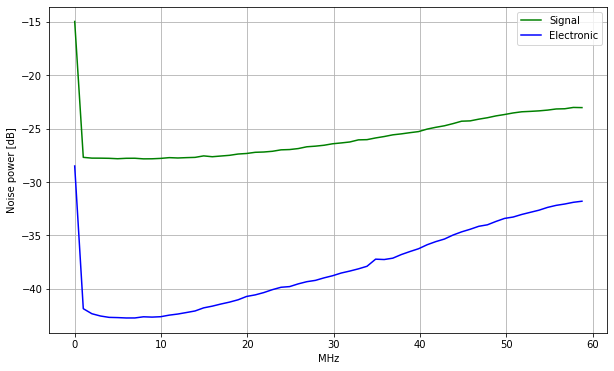

In [5]:
# Input state data
input_data_folder = "20240222/"#"input/"
#voltage_folder = '001/'#extra[extra.find('voltage') + len('voltage'): extra.find('-')]
input_extra = '1/'

input_folder = {'vac': path['vac'], '001': folder + date[v] + input_data_folder + '001/1/', '002': folder + date[v] + input_data_folder + '002/1'}

# Apply temporal mode function to a single data
#mf_homodyne, mf_vacuum, input_rho = apply_mode_function(homodyne, vacuum, input_folder = input_folder, input_plot = False)

# Apply temporal mode function to multilple data
mf_homodyne = {v: None for v in voltages}
mf_vacuum = {v: None for v in voltages}
input_rho = {v: None for v in voltages}
input_data = {v: None for v in voltages}

####### Change mode function parameters here
for v in voltages: 
    mf_homodyne[v], mf_vacuum[v] = data[v].apply_mode_function(homodyne[v], vacuum[v])#, homodyne_time_delay=-317e-9)
    input_data[v] = inputstate.inputstate(input_folder[v], n_dim, data[v].mf, input_plot = False, sweep_angle = True, losses = True)
amount_of_angles = len(input_data['vac'].input_rho)
    
## Select data

# Find coincidences    
time_window = 4e-9
coincidence = {v: coincidencecheck.selectdata(mf_homodyne[v], charlie[v], data[v].meta, time_window, verbose = False) for v in voltages}
sig = {v: None for v in voltages}
success_rate = {v: None for v in voltages}
for v in voltages:
    sig[v], success_rate[v] = coincidence[v].select_teleported_data()
    
        
## Calculate output state

# Calculate output state for data with coincidence
rho = {v: np.zeros((n_dim+1, n_dim+1), dtype = complex) for v in voltages}
fidelity = {v: np.zeros(amount_of_angles) for v in voltages}
for v in voltages:
    for j in range(amount_of_angles):
        rho[v], fidelity[v][j] = functions.calculate_output_state(sig[v], input_data[v].input_rho[j], success_rate, n_dim, plot = False, verbose = False)

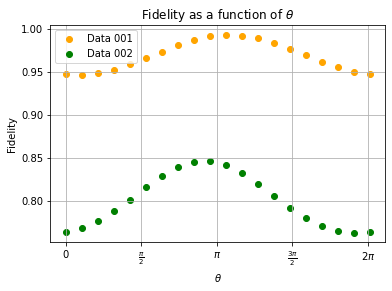

In [8]:
theta_list = np.linspace(0, 2*np.pi, amount_of_angles)
labels = ['Data vac', 'Data 001', 'Data 002']
colors = ['blue', 'orange', 'green']

# Fidelity with vacuum
rho_vac = np.zeros((n_dim+1, n_dim+1))
rho_vac[0][0] = 1
fid_vac = [functions.quantumStateFidelity(rho_vac, input_data[v].input_rho[0]) for v in voltages]

snr = [20, 107.5, 900]
# Simulated fidelity
input_alpha = [input_data[v].input_alpha for v in voltages]#[np.trace(functions.a_operator(n_dim)@input_data[v].input_rho[0]) for v in voltages]
sim_fidelity = {v: None for v in voltages}
sim_purity = {v: None for v in voltages}
for j, v in enumerate(voltages):
    sim_fidelity[v], _, sim_purity[v] = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7)
    #_, _, _, out_rho = scissor.quantum_scissor(input_alpha[j], dimension, single_photon_efficiency=single_photon_efficiency, alice_transmission=alice_transmission, bob_transmission=bob_transmission, hd_eff = 0.7, output = True)
    #sim_fidelity[v] = scissor.quantum_fidelity(qutip.coherent_dm(dimension, input_alpha[j]*np.exp(1j*np.pi)), out_rho)
sim_fidelity_list = [sim_fidelity[v] for v in voltages]

plt.figure()
for j, v in enumerate(voltages):
    if j == 0:
        pass
    else:
        plt.scatter(theta_list, fidelity[v], color = colors[j], label = labels[j])
        #plt.axhline(y = fid_vac[j], color = colors[j], linestyle = ':')
        #plt.axhline(y = sim_fidelity[v], color = colors[j], linestyle = '--')
plt.grid()
plt.title('Fidelity as a function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('Fidelity')
plt.xticks(np.arange(0, 2*np.pi, step=(np.pi/2-0.01)), ['0','$\\frac{\\pi}{2}$','$\\pi$','$\\frac{3\\pi}{2}$', '$2\\pi$'])
plt.legend()
plt.show()

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


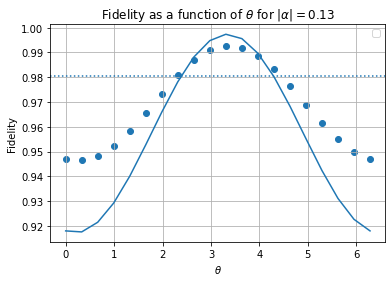

In [7]:
amp = input_data['001'].input_alpha
alpha_list = [amp*np.exp(1j*(ph+np.pi-np.pi/16)) for ph in theta_list]

fid_loss = []
for alpha in alpha_list:
    fid_ph_loss, _, _, rho_loss = scissor.quantum_scissor(alpha, dimension, single_photon_efficiency = single_photon_efficiency, alice_transmission = alice_transmission, bob_transmission = bob_transmission, output = True)
    fid_loss.append(scissor.quantum_fidelity(qutip.coherent_dm(dimension, amp), rho_loss))

plt.figure()
plt.scatter(theta_list, fidelity['001'])
plt.axhline(y = fid_vac[1], linestyle = ':')
plt.plot(theta_list, fid_loss)
#plt.axhline(y = sim_fidelity['001'], linestyle = '--')
plt.grid()
plt.title('Fidelity as a function of $\\theta$ for $|\\alpha| = $' + str(int(amp*100)/100))
plt.xlabel('$\\theta$')
plt.ylabel('Fidelity')
plt.legend()
plt.show()

0.27544939952616854


<ipython-input-8-fb1c21603d62>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_loss[i][j] = scissor.quantum_fidelity(qutip.coherent_dm(dimension, amps[i]), rho_loss)


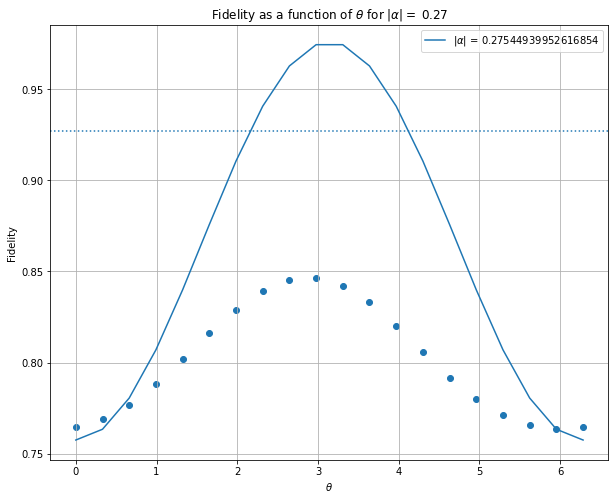

In [8]:
amps = np.linspace(0.2, 0.3, 5)
amps = [input_data['002'].input_alpha]
alpha_list = [[amp*np.exp(1j*(ph+np.pi)) for ph in theta_list] for amp in amps]

fid_loss = np.zeros((len(amps), len(alpha_list[0])))
for i in range(len(amps)):
    print(amps[i])
    for j, alpha in enumerate(alpha_list[i]):
        fid_ph_loss, _, _, rho_loss = scissor.quantum_scissor(alpha, dimension, single_photon_efficiency = single_photon_efficiency, alice_transmission = alice_transmission, bob_transmission = bob_transmission, output = True)
        fid_loss[i][j] = scissor.quantum_fidelity(qutip.coherent_dm(dimension, amps[i]), rho_loss)

size = (10,8)
        
plt.figure(figsize = size)
plt.scatter(theta_list, fidelity['002'])
plt.axhline(y = fid_vac[2], linestyle = ':')
for j, amp in enumerate(amps):
    plt.plot(theta_list, fid_loss[j], label = '$|\\alpha|$ = ' + str(amp))
#plt.axhline(y = sim_fidelity['001'], linestyle = '--')
plt.grid()
plt.title('Fidelity as a function of $\\theta$ for $|\\alpha| = $ ' + str(int(amps[0]*100)/100))
plt.xlabel('$\\theta$')
plt.ylabel('Fidelity')
plt.legend()
plt.show()

# Varying mode function parameters

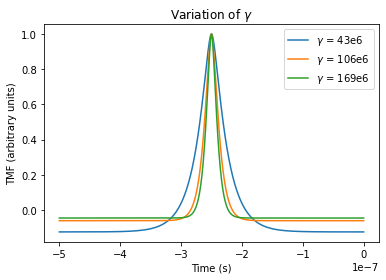

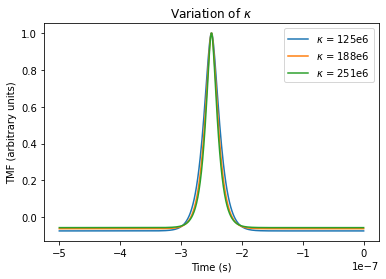

In [83]:
## Effect of changing mode function parameters

t_axis = np.linspace(-500e-9, 0, 500)
tmf_t = [functions.mode_function(kappa, gamma, t0, t) for t in t_axis]

kappa = 2*np.pi*30e6
gamma = 2*np.pi*17e6
t0 = -250e-9

## Variation of gamma
gamma_window = 2*np.pi*10e6
gamma_points = 3
gamma_list = np.linspace(gamma - gamma_window, gamma + gamma_window, gamma_points)

tmf_g = np.zeros((gamma_points, len(t_axis)))
tmf_g_norm = np.zeros((gamma_points, len(t_axis)))
for g in range(gamma_points):
    tmf_g[g] = [functions.mode_function(kappa, gamma_list[g], t0, t) for t in t_axis]
    tmf_g_norm[g] = (tmf_g[g] - tmf_g[g].mean())/(tmf_g[g].max() - tmf_g[g].mean())

plt.figure()
plt.title('Variation of $\\gamma$')
for g in range(gamma_points):
    plt.plot(t_axis, tmf_g_norm[g], label = '$\\gamma$ = ' + str(int(gamma_list[g]*10**-6)) + 'e6')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('TMF (arbitrary units)')
plt.show()

## Variation of kappa
kappa_window = 2*np.pi*10e6
kappa_points = 3
kappa_list = np.linspace(kappa - kappa_window, kappa + kappa_window, kappa_points)

tmf_k = np.zeros((kappa_points, len(t_axis)))
tmf_k_norm = np.zeros((kappa_points, len(t_axis)))
for k in range(kappa_points):
    tmf_k[k] = [functions.mode_function(kappa_list[k], gamma, t0, t) for t in t_axis]
    tmf_k_norm[k] = (tmf_k[k] - tmf_k[k].mean())/(tmf_k[k].max() - tmf_k[k].mean())

plt.figure()
plt.title('Variation of $\\kappa$')
for k in range(kappa_points):
    plt.plot(t_axis, tmf_k_norm[k], label = '$\\kappa$ = ' + str(int(kappa_list[k]*10**-6)) + 'e6')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('TMF (arbitrary units)')
plt.show()

# Vary g

VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


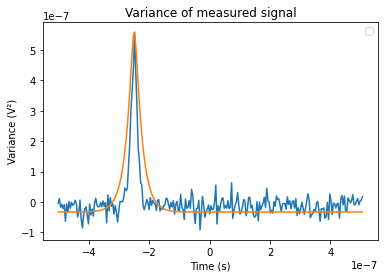

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


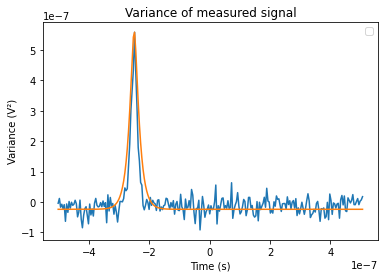

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


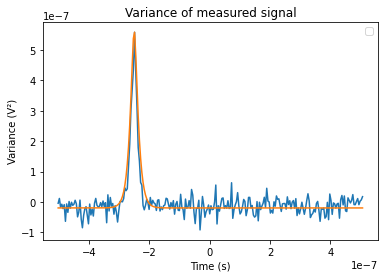

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


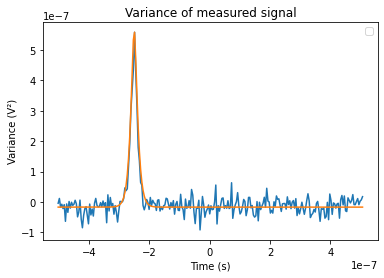

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


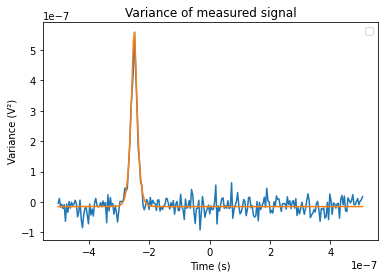

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


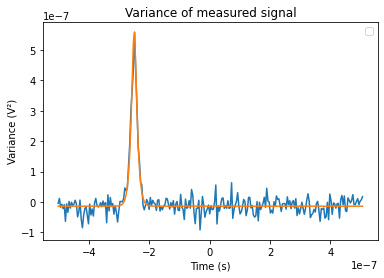

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


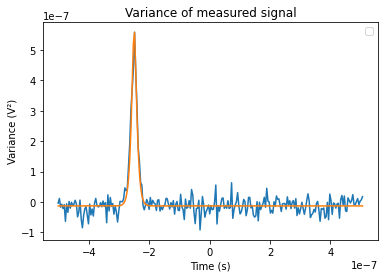

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


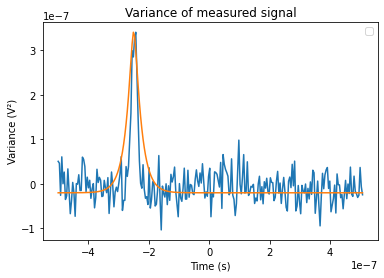

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.19612279160042115
Block 1 Input |\alpha| = 0.12027676392189364
Block 2 Input |\alpha| = 0.10692427010346296
Block 3 Input |\alpha| = 0.21968194931072374
Block 4 Input |\alpha| = 0.08632871929871937
Block 5 Input |\alpha| = 0.1675287137966006
Block 6 Input |\alpha| = 0.15706754992050587
Block 7 Input |\alpha| = 0.2100412055724898
Block 8 Input |\alpha| = 0.20063022836422598
Block 9 Input |\alpha| = 0.18290559546174784
Input |\alpha| averaged through all blocks: 0.16 (0.04)
Input angle averaged through all blocks: 87.05 (11.49)°
Input |alpha| = 0.16
Relay theta = 90.00°
Input state theta = 87.05°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


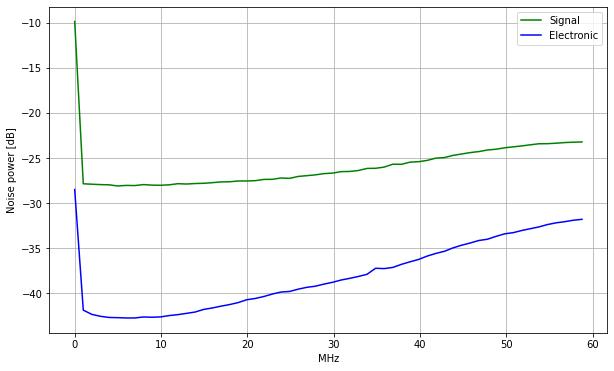

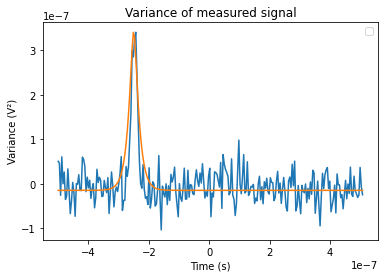

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1599036169369662
Block 1 Input |\alpha| = 0.10001743533020702
Block 2 Input |\alpha| = 0.08796040134938621
Block 3 Input |\alpha| = 0.19596467944617849
Block 4 Input |\alpha| = 0.06534640837143246
Block 5 Input |\alpha| = 0.14679317081554585
Block 6 Input |\alpha| = 0.13144335097469115
Block 7 Input |\alpha| = 0.17760252116739828
Block 8 Input |\alpha| = 0.1821822468055591
Block 9 Input |\alpha| = 0.15444607858313922
Input |\alpha| averaged through all blocks: 0.14 (0.04)
Input angle averaged through all blocks: 87.68 (13.84)°
Input |alpha| = 0.14
Relay theta = 90.00°
Input state theta = 87.68°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


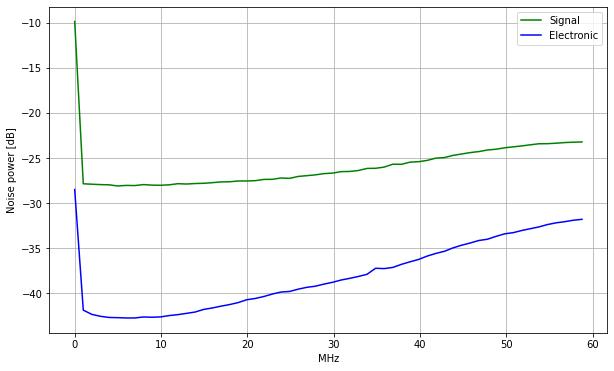

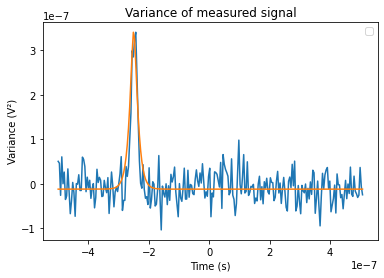

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.13866285525186847
Block 1 Input |\alpha| = 0.09150843229051822
Block 2 Input |\alpha| = 0.07838350954678674
Block 3 Input |\alpha| = 0.1800936008522055
Block 4 Input |\alpha| = 0.053041349534809004
Block 5 Input |\alpha| = 0.13495678546111578
Block 6 Input |\alpha| = 0.11427444824770341
Block 7 Input |\alpha| = 0.15540590456496947
Block 8 Input |\alpha| = 0.17117277000849462
Block 9 Input |\alpha| = 0.13605454534745268
Input |\alpha| averaged through all blocks: 0.13 (0.04)
Input angle averaged through all blocks: 87.92 (15.87)°
Input |alpha| = 0.13
Relay theta = 90.00°
Input state theta = 87.92°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


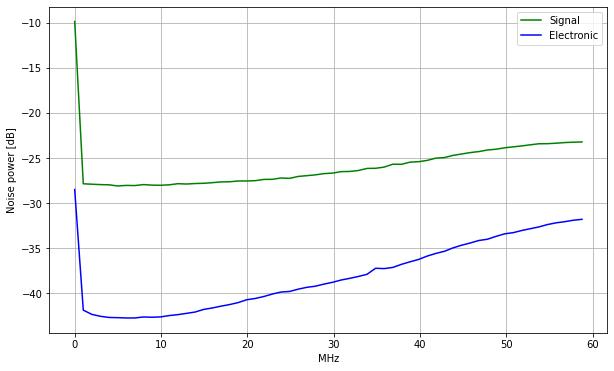

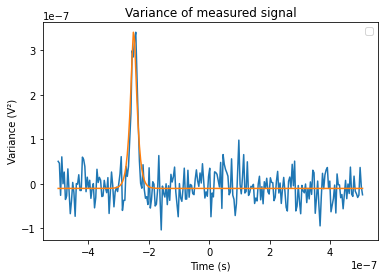

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1245956103497702
Block 1 Input |\alpha| = 0.08728945842394127
Block 2 Input |\alpha| = 0.07279673246767603
Block 3 Input |\alpha| = 0.16860820370545546
Block 4 Input |\alpha| = 0.045000865309918855
Block 5 Input |\alpha| = 0.12754755955589653
Block 6 Input |\alpha| = 0.10245029437672988
Block 7 Input |\alpha| = 0.13927873368607896
Block 8 Input |\alpha| = 0.1634270323025909
Block 9 Input |\alpha| = 0.12285609624709849
Input |\alpha| averaged through all blocks: 0.12 (0.04)
Input angle averaged through all blocks: 87.89 (17.64)°
Input |alpha| = 0.12
Relay theta = 90.00°
Input state theta = 87.89°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


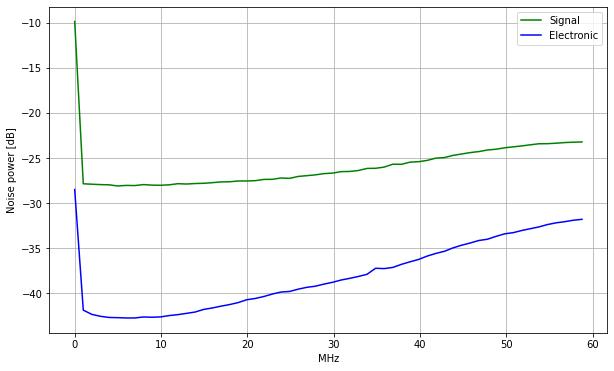

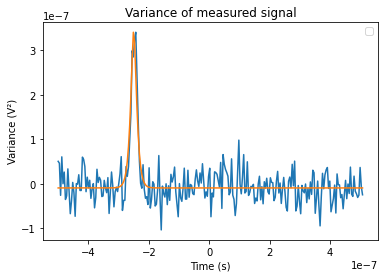

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.11441424087681894
Block 1 Input |\alpha| = 0.08485369795265905
Block 2 Input |\alpha| = 0.06913002375409569
Block 3 Input |\alpha| = 0.15987524812873544
Block 4 Input |\alpha| = 0.03946211423934899
Block 5 Input |\alpha| = 0.12261855681436587
Block 6 Input |\alpha| = 0.09408786301268046
Block 7 Input |\alpha| = 0.1271072633280666
Block 8 Input |\alpha| = 0.15744353517837772
Block 9 Input |\alpha| = 0.11283889293338942
Input |\alpha| averaged through all blocks: 0.11 (0.04)
Input angle averaged through all blocks: 87.68 (19.20)°
Input |alpha| = 0.11
Relay theta = 90.00°
Input state theta = 87.68°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


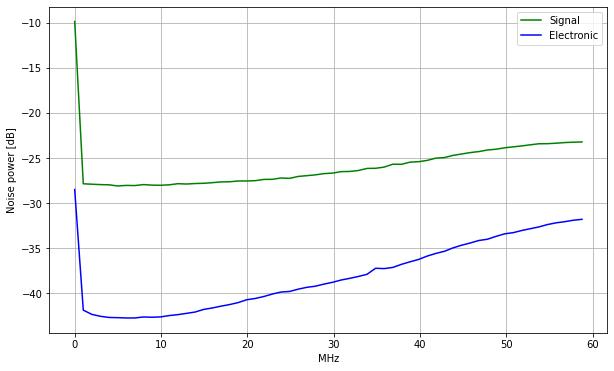

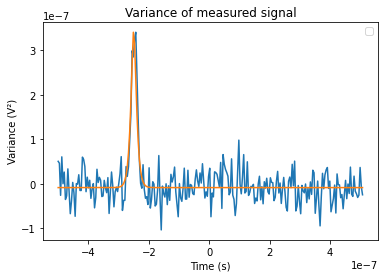

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.10657788080581213
Block 1 Input |\alpha| = 0.08324718996284798
Block 2 Input |\alpha| = 0.06651676891467893
Block 3 Input |\alpha| = 0.1529976337893446
Block 4 Input |\alpha| = 0.0355588026917264
Block 5 Input |\alpha| = 0.11917531577264544
Block 6 Input |\alpha| = 0.08802633419397966
Block 7 Input |\alpha| = 0.11766296265022809
Block 8 Input |\alpha| = 0.1525722682576692
Block 9 Input |\alpha| = 0.10500032713125713
Input |\alpha| averaged through all blocks: 0.10 (0.03)
Input angle averaged through all blocks: 87.36 (20.61)°
Input |alpha| = 0.10
Relay theta = 90.00°
Input state theta = 87.36°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


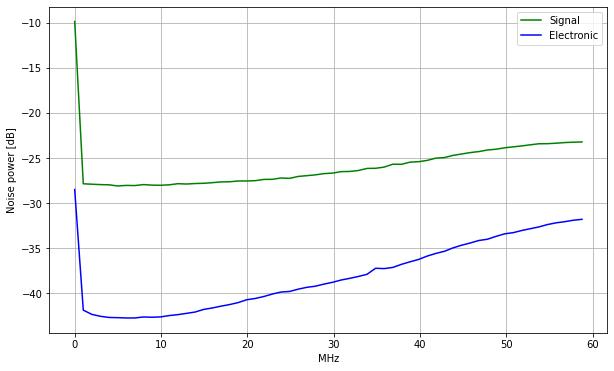

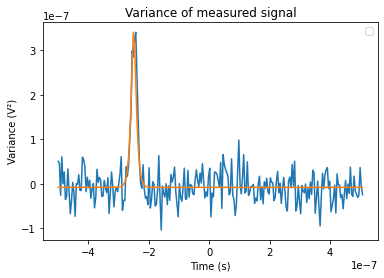

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.10029576070604554
Block 1 Input |\alpha| = 0.0820707298019478
Block 2 Input |\alpha| = 0.06455602537638779
Block 3 Input |\alpha| = 0.14743944927208513
Block 4 Input |\alpha| = 0.03279335612794605
Block 5 Input |\alpha| = 0.11666420991013873
Block 6 Input |\alpha| = 0.08353778152025537
Block 7 Input |\alpha| = 0.11017460669686582
Block 8 Input |\alpha| = 0.14848613655486867
Block 9 Input |\alpha| = 0.09875071944640085
Input |\alpha| averaged through all blocks: 0.10 (0.03)
Input angle averaged through all blocks: 86.96 (21.89)°
Input |alpha| = 0.10
Relay theta = 90.00°
Input state theta = 86.96°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


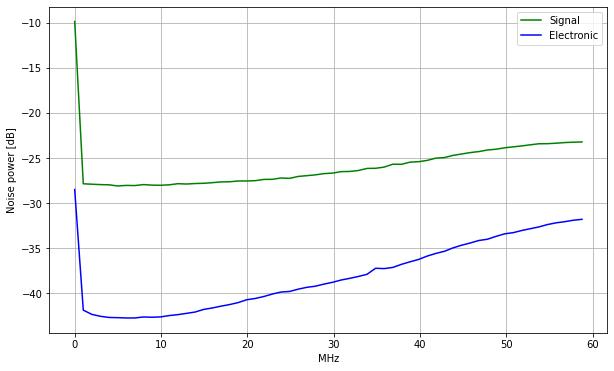

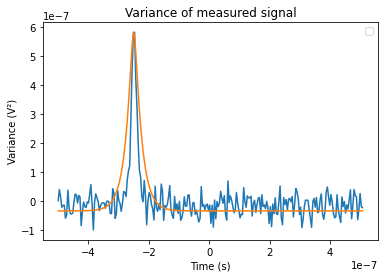

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.2797125782472804
Block 1 Input |\alpha| = 0.3510680826842203
Block 2 Input |\alpha| = 0.33434167748357463
Block 3 Input |\alpha| = 0.3297860800615545
Block 4 Input |\alpha| = 0.31801987451423624
Block 5 Input |\alpha| = 0.3375030591198803
Block 6 Input |\alpha| = 0.307330724288542
Block 7 Input |\alpha| = 0.3178410481962315
Block 8 Input |\alpha| = 0.3861980999964998
Block 9 Input |\alpha| = 0.35075706384515004
Input |\alpha| averaged through all blocks: 0.33 (0.03)
Input angle averaged through all blocks: 158.45 (5.64)°
Input |alpha| = 0.33
Relay theta = 90.00°
Input state theta = 158.45°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


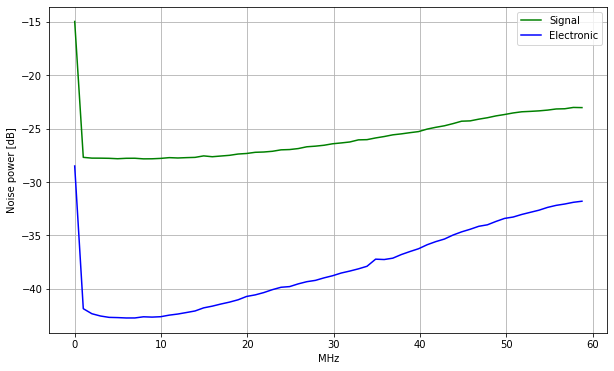

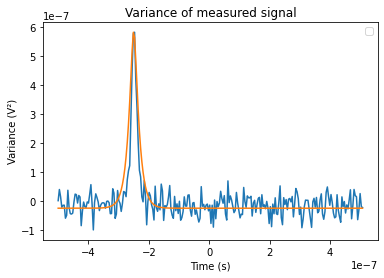

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.22949373380510085
Block 1 Input |\alpha| = 0.30550835303255364
Block 2 Input |\alpha| = 0.28605475182415463
Block 3 Input |\alpha| = 0.27654133754946114
Block 4 Input |\alpha| = 0.26286305236318647
Block 5 Input |\alpha| = 0.2719372450821897
Block 6 Input |\alpha| = 0.25628909272820377
Block 7 Input |\alpha| = 0.2662960109839404
Block 8 Input |\alpha| = 0.33961355882120886
Block 9 Input |\alpha| = 0.3049241018842695
Input |\alpha| averaged through all blocks: 0.28 (0.03)
Input angle averaged through all blocks: 158.87 (6.10)°
Input |alpha| = 0.28
Relay theta = 90.00°
Input state theta = 158.87°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


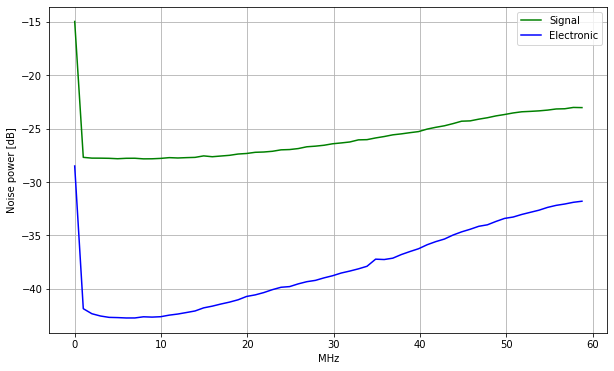

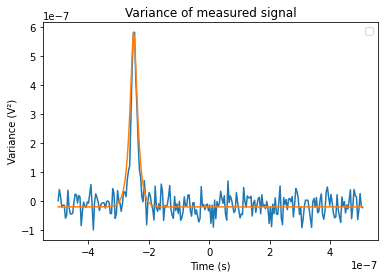

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.19953518113098384
Block 1 Input |\alpha| = 0.27576722993088904
Block 2 Input |\alpha| = 0.25614472828192053
Block 3 Input |\alpha| = 0.24426546347537326
Block 4 Input |\alpha| = 0.23318056054635744
Block 5 Input |\alpha| = 0.23084743783680473
Block 6 Input |\alpha| = 0.22414905084626663
Block 7 Input |\alpha| = 0.23744323453907887
Block 8 Input |\alpha| = 0.311208794846969
Block 9 Input |\alpha| = 0.2747103857576865
Input |\alpha| averaged through all blocks: 0.25 (0.03)
Input angle averaged through all blocks: 159.13 (6.53)°
Input |alpha| = 0.25
Relay theta = 90.00°
Input state theta = 159.13°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


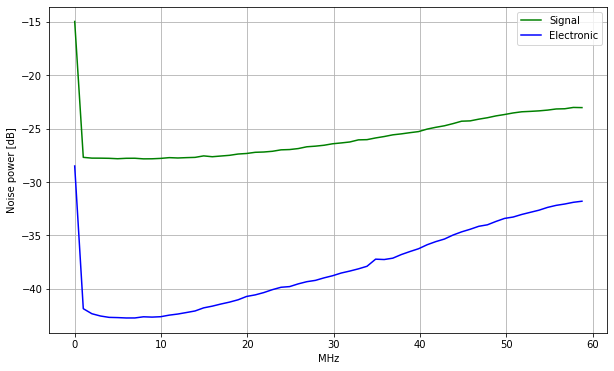

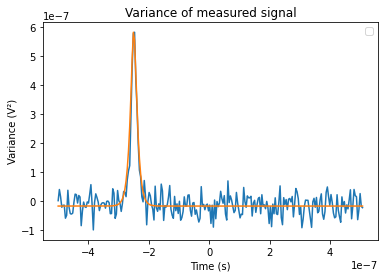

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.17933355489149827
Block 1 Input |\alpha| = 0.2549534275544496
Block 2 Input |\alpha| = 0.23504284067892467
Block 3 Input |\alpha| = 0.22242694760728812
Block 4 Input |\alpha| = 0.21529714645640805
Block 5 Input |\alpha| = 0.2026769620373596
Block 6 Input |\alpha| = 0.2019471160528192
Block 7 Input |\alpha| = 0.21892438061583927
Block 8 Input |\alpha| = 0.29117526412848815
Block 9 Input |\alpha| = 0.25267092000786795
Input |\alpha| averaged through all blocks: 0.23 (0.03)
Input angle averaged through all blocks: 159.32 (6.97)°
Input |alpha| = 0.23
Relay theta = 90.00°
Input state theta = 159.32°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


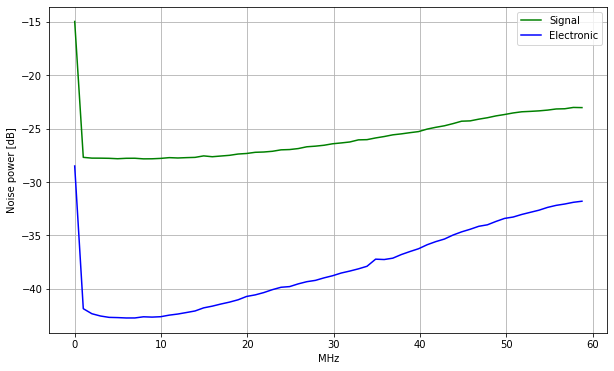

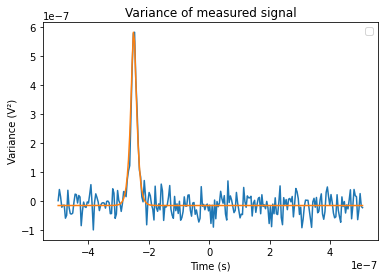

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.1647455325426295
Block 1 Input |\alpha| = 0.23981852927355796
Block 2 Input |\alpha| = 0.21894690055642896
Block 3 Input |\alpha| = 0.20651818972124703
Block 4 Input |\alpha| = 0.20363311187708483
Block 5 Input |\alpha| = 0.18229833208491172
Block 6 Input |\alpha| = 0.18572640444547844
Block 7 Input |\alpha| = 0.20585727566453216
Block 8 Input |\alpha| = 0.2758813655699393
Block 9 Input |\alpha| = 0.2357629516699259
Input |\alpha| averaged through all blocks: 0.21 (0.03)
Input angle averaged through all blocks: 159.48 (7.42)°
Input |alpha| = 0.21
Relay theta = 90.00°
Input state theta = 159.48°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


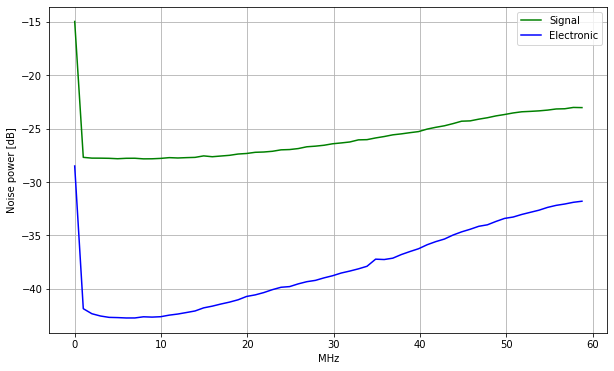

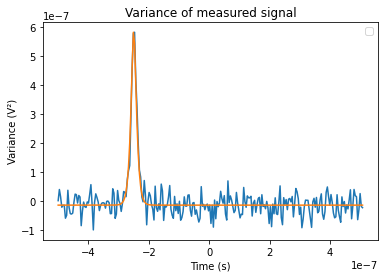

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.1537377583939847
Block 1 Input |\alpha| = 0.2285007390181578
Block 2 Input |\alpha| = 0.2060509526869074
Block 3 Input |\alpha| = 0.19429908855403763
Block 4 Input |\alpha| = 0.1955589961304016
Block 5 Input |\alpha| = 0.16703320776956254
Block 6 Input |\alpha| = 0.17341969920234235
Block 7 Input |\alpha| = 0.19599083106050685
Block 8 Input |\alpha| = 0.2636697425233695
Block 9 Input |\alpha| = 0.2223807279180815
Input |\alpha| averaged through all blocks: 0.20 (0.03)
Input angle averaged through all blocks: 159.65 (7.87)°
Input |alpha| = 0.20
Relay theta = 90.00°
Input state theta = 159.65°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


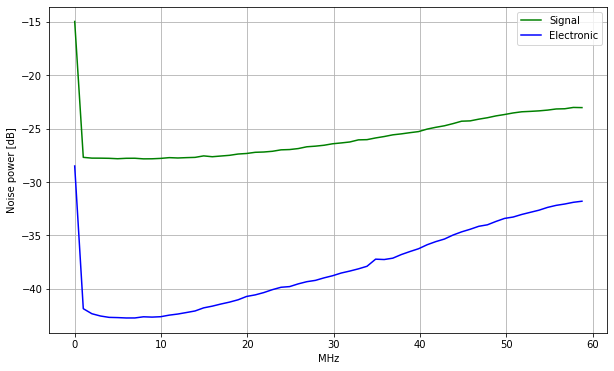

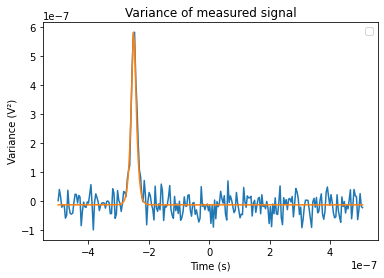

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.1451680641263993
Block 1 Input |\alpha| = 0.2198372528465706
Block 2 Input |\alpha| = 0.19538811400765693
Block 3 Input |\alpha| = 0.18454317015420066
Block 4 Input |\alpha| = 0.1896973495674214
Block 5 Input |\alpha| = 0.15530964623871713
Block 6 Input |\alpha| = 0.1638168473687927
Block 7 Input |\alpha| = 0.1881722508905268
Block 8 Input |\alpha| = 0.25365023221899025
Block 9 Input |\alpha| = 0.21155218703842377
Input |\alpha| averaged through all blocks: 0.19 (0.03)
Input angle averaged through all blocks: 159.82 (8.31)°
Input |alpha| = 0.19
Relay theta = 90.00°
Input state theta = 159.82°
PLOTS FOR INPUT STATE
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.43 %
Success rate = 0.43 %


<ipython-input-10-52d27af7c9b1>:52: ComplexWarning: Casting complex values to real discards the imaginary part
  rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v][i].input_rho, success_rate[v], n_dim, plot = False, verbose = False)


Converged
98 runs
|alpha| = 0.02
theta = -61.96°
Converged
110 runs
|alpha| = 0.02
theta = -60.46°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
150 runs
|alpha| = 0.01
theta = -46.22°
Converged
79 runs
|alpha| = 0.00
theta = -57.02°
Converged
83 runs
|alpha| = 0.00
theta = -35.91°
Converged
101 runs
|alpha| = 0.08
theta = 8.90°
Converged
134 runs
|alpha| = 0.09
theta = 7.97°
Converged
158 runs
|alpha| = 0.09
theta = 8.65°
Converged
154 runs
|alpha| = 0.08
theta = 10.08°
Converged
153 runs
|alpha| = 0.08
theta = 11.64°
Converged
132 runs
|alpha| = 0.08
theta = 13.21°
Converged
124 runs
|alpha| = 0.08
theta = 14.50°
Converged
108 runs
|alpha| = 0.08
theta = 58.66°
Converged
139 runs
|alpha| = 0.08
theta = 55.29°
Converged
113 runs
|alpha| = 0.07
theta = 53.32°
Converged
141 runs
|alpha| = 0.07
theta = 51.09°
Converged
115 runs
|alpha| = 0.07
theta = 46.16°
Converged
118 runs
|alpha| = 0.06
theta = 44.28°
Converged
113 runs
|alpha| = 0.06
theta = 41.70°


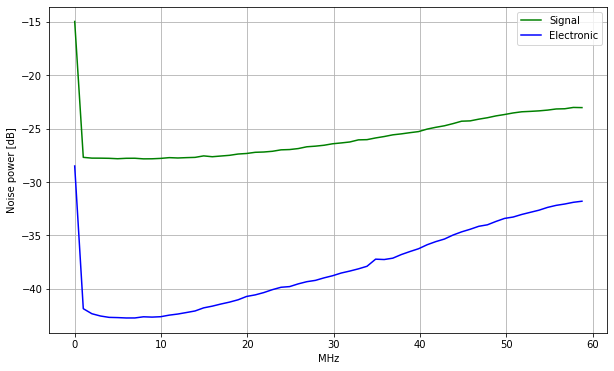

In [10]:
# Input state data
input_data_folder = "20240222/"#"input/"
#voltage_folder = '001/'#extra[extra.find('voltage') + len('voltage'): extra.find('-')]
input_extra = '1/'

input_folder = {'vac': path['vac'], '001': folder + date[v] + input_data_folder + '001/1/', '002': folder + date[v] + input_data_folder + '002/1'}

# Apply temporal mode function to a single data
#mf_homodyne, mf_vacuum, input_rho = apply_mode_function(homodyne, vacuum, input_folder = input_folder, input_plot = False)

# Mode function parameter to vary
g_med = 2*np.pi*17e6
window = 2*np.pi*10e6
points = 7
g_list = np.linspace(g_med - window, g_med + window, points)

# Apply temporal mode function to multilple data
mf_homodyne = {v: [] for v in voltages}
mf_vacuum = {v: [] for v in voltages}
input_rho = {v: [] for v in voltages}
input_data = {v: [] for v in voltages}

for v in voltages:
    for j, g in enumerate(g_list):
        homo, vac = data[v].apply_mode_function(homodyne[v], vacuum[v], homodyne_g=g)
        mf_homodyne[v].append(homo)
        mf_vacuum[v].append(vac)
        
        input_data[v].append(inputstate.inputstate(input_folder[v], n_dim, data[v].mf, input_plot = False))

        
## Coincidences
        
# SSPD time delay information
sspd_time_delay = 100e-9
window = 4e-9

# Obtain data and success rate for multiple data and varying mode function parameter
coincidence = {v: [coincidencecheck.selectdata(mf_homodyne[v][g], charlie[v], data[v].meta, window, verbose = False) for g in range(len(g_list))] for v in voltages}
sig = {v: [None for g in range(len(g_list))] for v in voltages}
success_rate = {v: [None for g in range(len(g_list))] for v in voltages}
for v in voltages:
    for g in range(len(g_list)):
        sig[v][g], success_rate[v] = coincidence[v][g].select_teleported_data()
          
# Calculate output state for multiple data and multiple time delays
runs = len(g_list)
rho = {v: np.zeros((runs, n_dim+1, n_dim+1), dtype = complex) for v in voltages}
fidelity = {v: np.zeros(runs) for v in voltages}
for v in voltages:
    for i in range(runs):
        rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v][i].input_rho, success_rate[v], n_dim, plot = False, verbose = False)

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


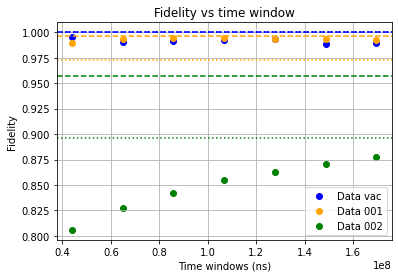

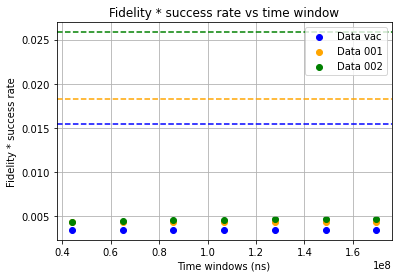

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


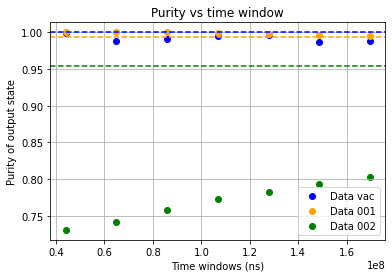

In [11]:
plot_mf_parameters(rho, input_data, fidelity, success_rate, g_list, voltages)

## Vary k 

VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


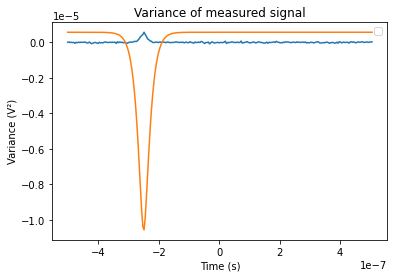

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


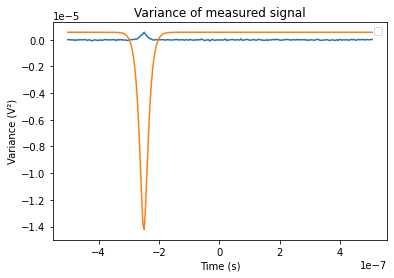

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


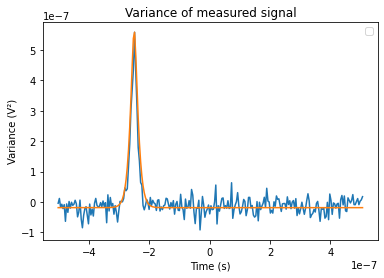

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


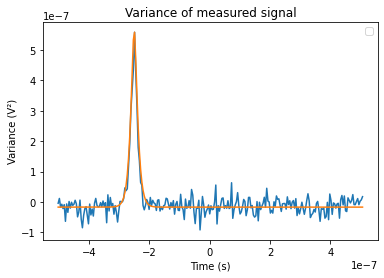

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


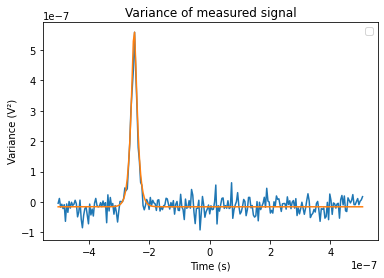

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


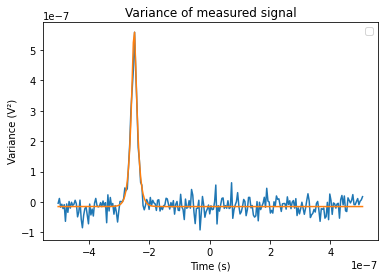

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


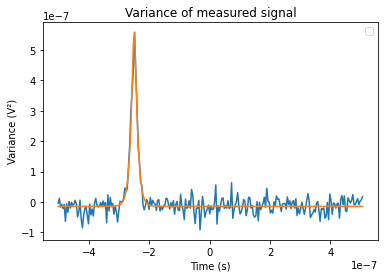

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


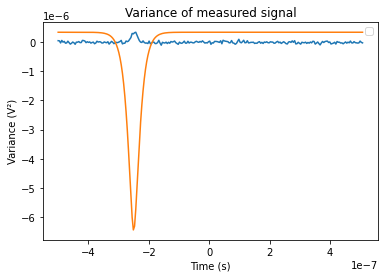

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.17774654040947654
Block 1 Input |\alpha| = 0.10670630585954968
Block 2 Input |\alpha| = 0.09626739405963566
Block 3 Input |\alpha| = 0.20787039077686412
Block 4 Input |\alpha| = 0.07637326590014344
Block 5 Input |\alpha| = 0.15590415195200275
Block 6 Input |\alpha| = 0.14607843679399238
Block 7 Input |\alpha| = 0.1964525058335101
Block 8 Input |\alpha| = 0.19002583711299467
Block 9 Input |\alpha| = 0.17098377689145558
Input |\alpha| averaged through all blocks: 0.15 (0.04)
Input angle averaged through all blocks: -92.55 (12.38)°
Input |alpha| = 0.15
Relay theta = 90.00°
Input state theta = -92.55°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


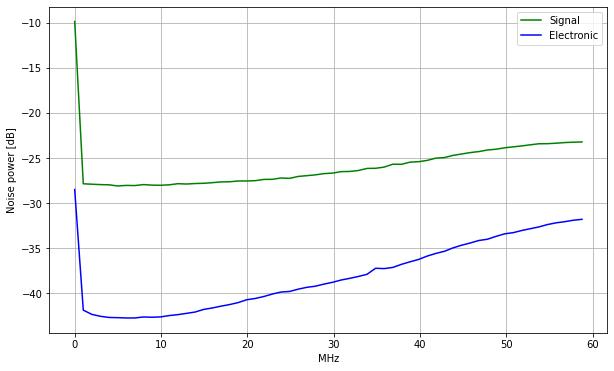

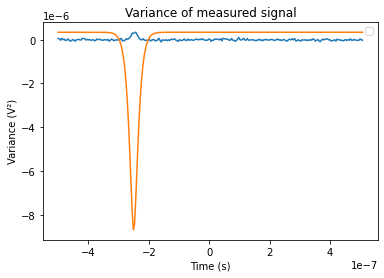

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.14700467135460202
Block 1 Input |\alpha| = 0.09284705024692681
Block 2 Input |\alpha| = 0.08137632461004106
Block 3 Input |\alpha| = 0.18645752684359557
Block 4 Input |\alpha| = 0.0581663538939742
Block 5 Input |\alpha| = 0.13825618427704472
Block 6 Input |\alpha| = 0.12142140014652017
Block 7 Input |\alpha| = 0.16572105757664823
Block 8 Input |\alpha| = 0.1750664081778839
Block 9 Input |\alpha| = 0.14519626904396488
Input |\alpha| averaged through all blocks: 0.13 (0.04)
Input angle averaged through all blocks: -92.02 (14.83)°
Input |alpha| = 0.13
Relay theta = 90.00°
Input state theta = -92.02°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


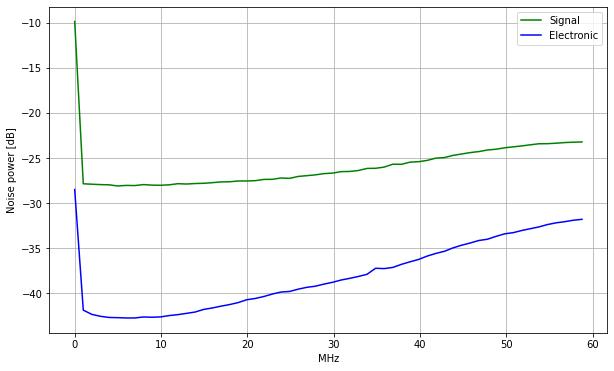

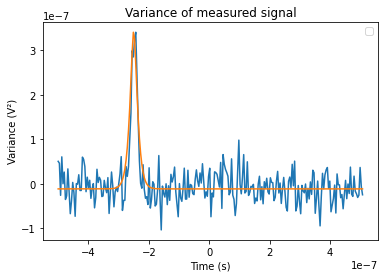

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1329207694457252
Block 1 Input |\alpha| = 0.08890893104373261
Block 2 Input |\alpha| = 0.07571098519461318
Block 3 Input |\alpha| = 0.17536848921513704
Block 4 Input |\alpha| = 0.04969432653651958
Block 5 Input |\alpha| = 0.131042276858445
Block 6 Input |\alpha| = 0.10919436269643981
Block 7 Input |\alpha| = 0.14927516805885135
Block 8 Input |\alpha| = 0.16790983402348292
Block 9 Input |\alpha| = 0.13144412745485476
Input |\alpha| averaged through all blocks: 0.12 (0.04)
Input angle averaged through all blocks: 88.03 (16.48)°
Input |alpha| = 0.12
Relay theta = 90.00°
Input state theta = 88.03°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


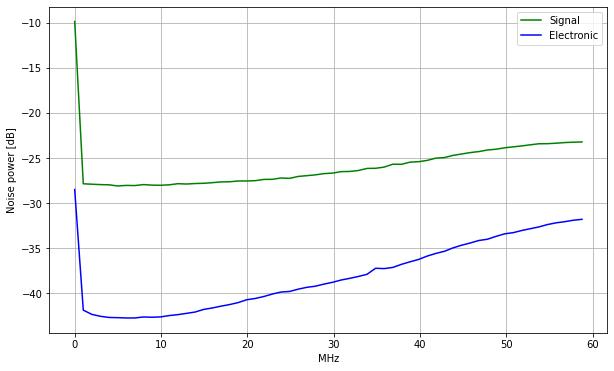

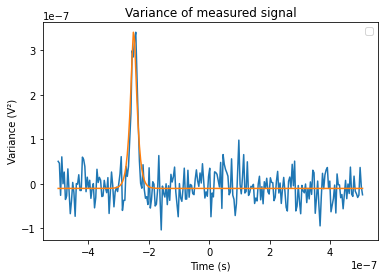

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.12459561034977018
Block 1 Input |\alpha| = 0.08728945842394126
Block 2 Input |\alpha| = 0.07279673246767603
Block 3 Input |\alpha| = 0.16860820370545543
Block 4 Input |\alpha| = 0.045000865309918855
Block 5 Input |\alpha| = 0.12754755955589653
Block 6 Input |\alpha| = 0.10245029437672991
Block 7 Input |\alpha| = 0.13927873368607893
Block 8 Input |\alpha| = 0.16342703230259087
Block 9 Input |\alpha| = 0.12285609624709849
Input |\alpha| averaged through all blocks: 0.12 (0.04)
Input angle averaged through all blocks: 87.89 (17.64)°
Input |alpha| = 0.12
Relay theta = 90.00°
Input state theta = 87.89°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


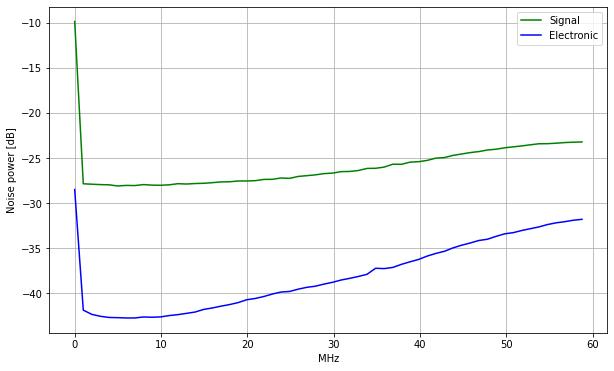

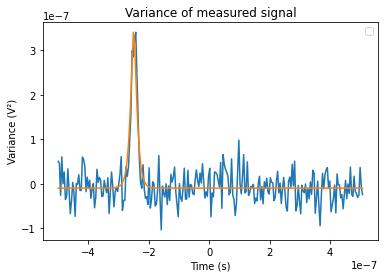

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.11899544923942204
Block 1 Input |\alpha| = 0.086433890659722
Block 2 Input |\alpha| = 0.07106789770108451
Block 3 Input |\alpha| = 0.16408869190954906
Block 4 Input |\alpha| = 0.0421877663310224
Block 5 Input |\alpha| = 0.12563614234412485
Block 6 Input |\alpha| = 0.09843694355991492
Block 7 Input |\alpha| = 0.13271421344831028
Block 8 Input |\alpha| = 0.16027262660629718
Block 9 Input |\alpha| = 0.11711262253055381
Input |\alpha| averaged through all blocks: 0.11 (0.04)
Input angle averaged through all blocks: 87.70 (18.50)°
Input |alpha| = 0.11
Relay theta = 90.00°
Input state theta = 87.70°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


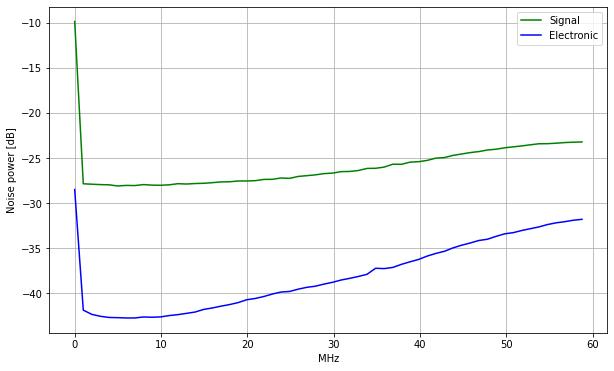

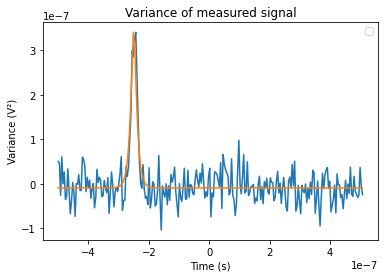

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.11496905943457747
Block 1 Input |\alpha| = 0.0859063066213995
Block 2 Input |\alpha| = 0.06996906893642178
Block 3 Input |\alpha| = 0.16088017015324071
Block 4 Input |\alpha| = 0.040425817538047935
Block 5 Input |\alpha| = 0.12447598509365435
Block 6 Input |\alpha| = 0.09591558989514173
Block 7 Input |\alpha| = 0.128163039514964
Block 8 Input |\alpha| = 0.15792257241724028
Block 9 Input |\alpha| = 0.1130976639352388
Input |\alpha| averaged through all blocks: 0.11 (0.04)
Input angle averaged through all blocks: 87.49 (19.17)°
Input |alpha| = 0.11
Relay theta = 90.00°
Input state theta = 87.49°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


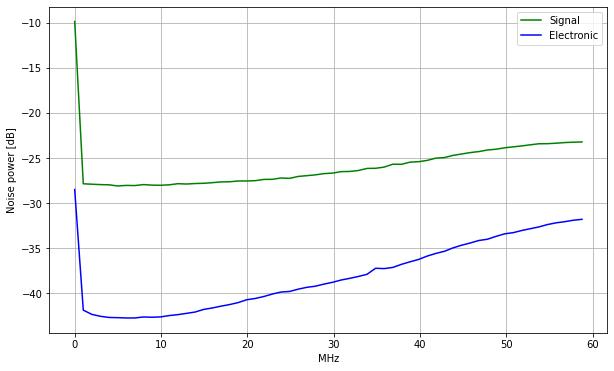

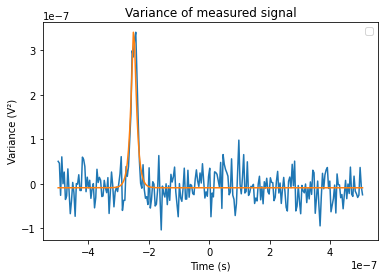

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.11196032225068836
Block 1 Input |\alpha| = 0.08555055349597576
Block 2 Input |\alpha| = 0.06924022650781801
Block 3 Input |\alpha| = 0.1585012444677673
Block 4 Input |\alpha| = 0.0392910130948774
Block 5 Input |\alpha| = 0.12370389160900488
Block 6 Input |\alpha| = 0.09426469752755404
Block 7 Input |\alpha| = 0.12487616228128025
Block 8 Input |\alpha| = 0.15611251925282527
Block 9 Input |\alpha| = 0.1101900276688972
Input |\alpha| averaged through all blocks: 0.11 (0.04)
Input angle averaged through all blocks: 87.30 (19.71)°
Input |alpha| = 0.11
Relay theta = 90.00°
Input state theta = 87.30°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


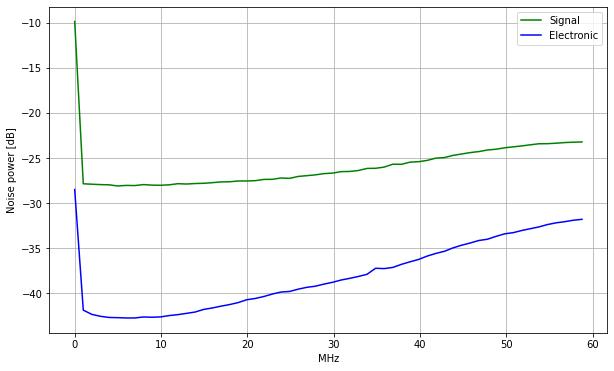

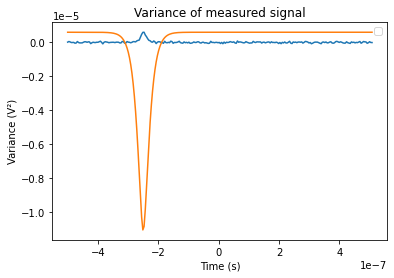

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.25520308162141675
Block 1 Input |\alpha| = 0.32926284268483286
Block 2 Input |\alpha| = 0.3103692417660578
Block 3 Input |\alpha| = 0.30353548943659703
Block 4 Input |\alpha| = 0.28736126219299074
Block 5 Input |\alpha| = 0.30749390378690955
Block 6 Input |\alpha| = 0.28417905564294227
Block 7 Input |\alpha| = 0.2891549946582446
Block 8 Input |\alpha| = 0.3617984630198787
Block 9 Input |\alpha| = 0.32960194785352476
Input |\alpha| averaged through all blocks: 0.31 (0.03)
Input angle averaged through all blocks: -21.33 (5.90)°
Input |alpha| = 0.31
Relay theta = 90.00°
Input state theta = -21.33°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


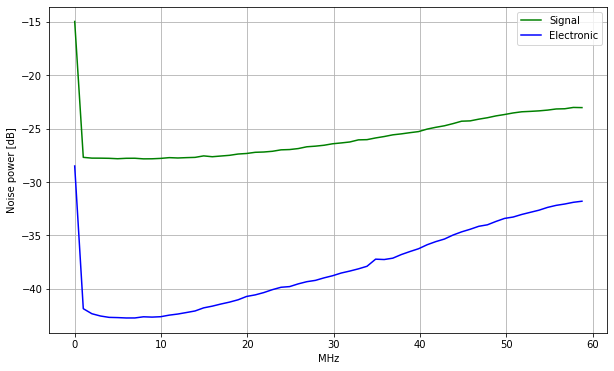

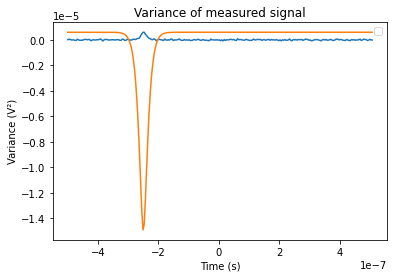

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.21187726310297234
Block 1 Input |\alpha| = 0.28730674155019786
Block 2 Input |\alpha| = 0.26870726784939364
Block 3 Input |\alpha| = 0.2572298082352618
Block 4 Input |\alpha| = 0.24195654183101215
Block 5 Input |\alpha| = 0.24851306501439177
Block 6 Input |\alpha| = 0.23810827634494056
Block 7 Input |\alpha| = 0.2472545154714013
Block 8 Input |\alpha| = 0.3225596297952626
Block 9 Input |\alpha| = 0.288230396127417
Input |\alpha| averaged through all blocks: 0.26 (0.03)
Input angle averaged through all blocks: -20.98 (6.36)°
Input |alpha| = 0.26
Relay theta = 90.00°
Input state theta = -20.98°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


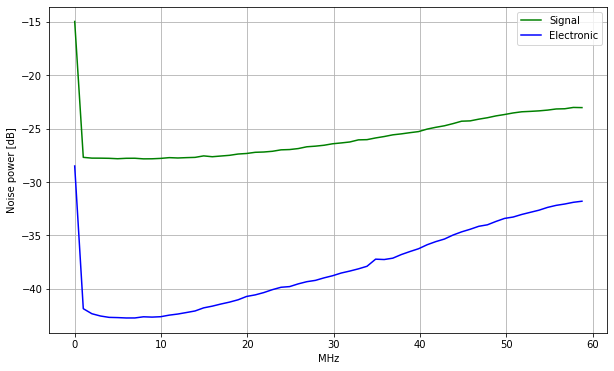

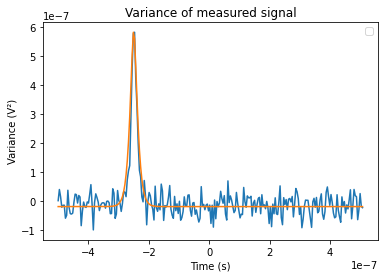

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.19127579129727498
Block 1 Input |\alpha| = 0.26658059127203365
Block 2 Input |\alpha| = 0.24797153655589108
Block 3 Input |\alpha| = 0.23528215524183438
Block 4 Input |\alpha| = 0.22407103609620027
Block 5 Input |\alpha| = 0.21946710359169122
Block 6 Input |\alpha| = 0.2152985679792296
Block 7 Input |\alpha| = 0.22916639192627705
Block 8 Input |\alpha| = 0.3031496941283421
Block 9 Input |\alpha| = 0.26629933061732874
Input |\alpha| averaged through all blocks: 0.24 (0.03)
Input angle averaged through all blocks: 159.19 (6.70)°
Input |alpha| = 0.24
Relay theta = 90.00°
Input state theta = 159.19°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


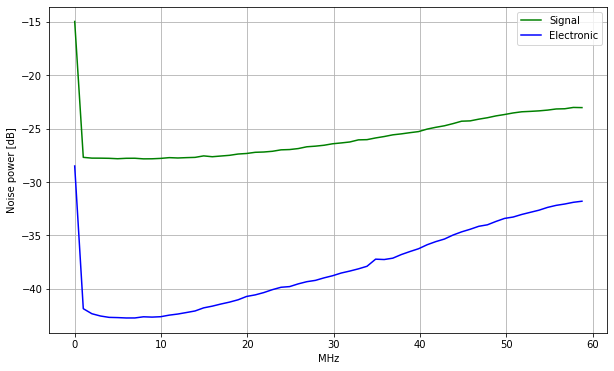

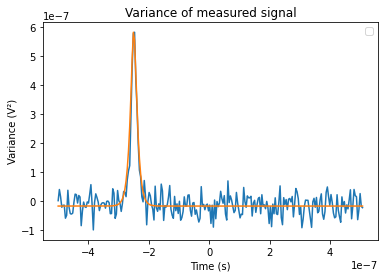

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.17933355489149824
Block 1 Input |\alpha| = 0.25495342755444955
Block 2 Input |\alpha| = 0.23504284067892464
Block 3 Input |\alpha| = 0.22242694760728812
Block 4 Input |\alpha| = 0.21529714645640805
Block 5 Input |\alpha| = 0.2026769620373596
Block 6 Input |\alpha| = 0.2019471160528192
Block 7 Input |\alpha| = 0.21892438061583927
Block 8 Input |\alpha| = 0.2911752641284881
Block 9 Input |\alpha| = 0.252670920007868
Input |\alpha| averaged through all blocks: 0.23 (0.03)
Input angle averaged through all blocks: 159.32 (6.97)°
Input |alpha| = 0.23
Relay theta = 90.00°
Input state theta = 159.32°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


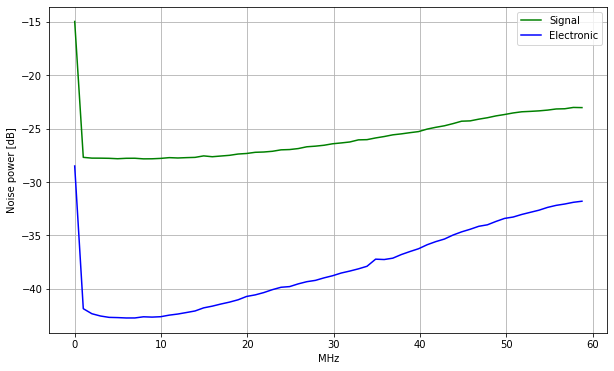

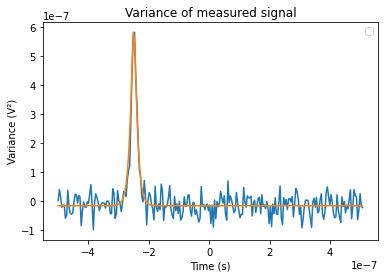

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.17165021851349146
Block 1 Input |\alpha| = 0.2478630624570007
Block 2 Input |\alpha| = 0.22602544219702939
Block 3 Input |\alpha| = 0.2139267488149449
Block 4 Input |\alpha| = 0.210350144212864
Block 5 Input |\alpha| = 0.192091747534845
Block 6 Input |\alpha| = 0.1933578596007104
Block 7 Input |\alpha| = 0.2121847341575476
Block 8 Input |\alpha| = 0.28302802152405865
Block 9 Input |\alpha| = 0.2434716929047842
Input |\alpha| averaged through all blocks: 0.22 (0.03)
Input angle averaged through all blocks: 159.44 (7.20)°
Input |alpha| = 0.22
Relay theta = 90.00°
Input state theta = 159.44°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


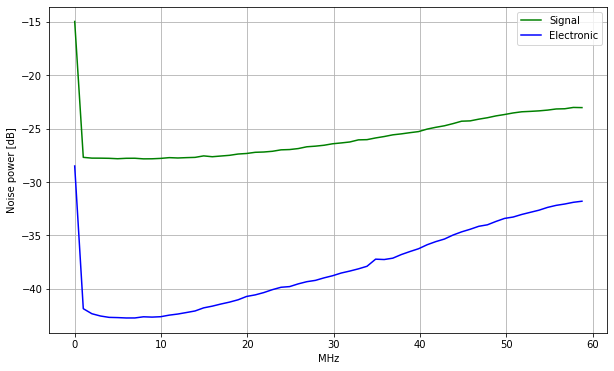

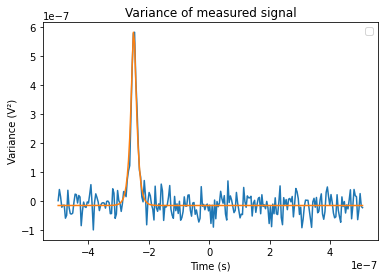

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.16636352084519127
Block 1 Input |\alpha| = 0.24325447478962767
Block 2 Input |\alpha| = 0.2193456708425955
Block 3 Input |\alpha| = 0.20787080407783765
Block 4 Input |\alpha| = 0.20725884114517668
Block 5 Input |\alpha| = 0.1850102052613648
Block 6 Input |\alpha| = 0.1874722313060612
Block 7 Input |\alpha| = 0.20735756256593604
Block 8 Input |\alpha| = 0.27717385583025067
Block 9 Input |\alpha| = 0.23692073269181188
Input |\alpha| averaged through all blocks: 0.21 (0.03)
Input angle averaged through all blocks: 159.55 (7.39)°
Input |alpha| = 0.21
Relay theta = 90.00°
Input state theta = 159.55°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


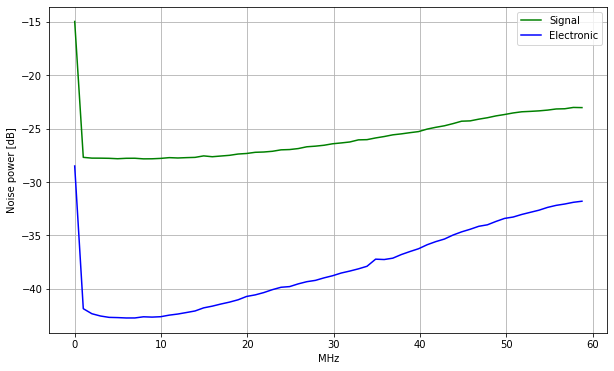

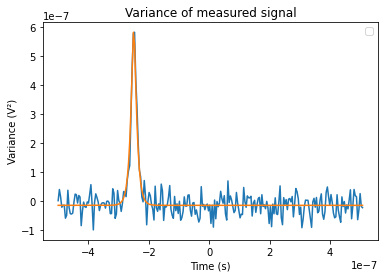

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.16254789381363927
Block 1 Input |\alpha| = 0.24010344693015956
Block 2 Input |\alpha| = 0.21421624957779742
Block 3 Input |\alpha| = 0.2033421073821579
Block 4 Input |\alpha| = 0.2051678632179792
Block 5 Input |\alpha| = 0.18005243031628757
Block 6 Input |\alpha| = 0.18325174631344615
Block 7 Input |\alpha| = 0.20372373578140665
Block 8 Input |\alpha| = 0.27281130959787725
Block 9 Input |\alpha| = 0.23207313893018572
Input |\alpha| averaged through all blocks: 0.21 (0.03)
Input angle averaged through all blocks: 159.65 (7.55)°
Input |alpha| = 0.21
Relay theta = 90.00°
Input state theta = 159.65°
PLOTS FOR INPUT STATE
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.43 %
Success rate = 0.43

<ipython-input-47-54490c1063d5>:52: ComplexWarning: Casting complex values to real discards the imaginary part
  rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v][i].input_rho, success_rate[v], n_dim, plot = False, verbose = False)


Converged
105 runs
|alpha| = 0.02
theta = -52.66°
Converged
112 runs
|alpha| = 0.01
theta = -58.52°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
145 runs
|alpha| = 0.01
theta = -46.66°
Converged
156 runs
|alpha| = 0.01
theta = -41.48°
Converged
180 runs
|alpha| = 0.01
theta = -34.51°
Converged
92 runs
|alpha| = 0.08
theta = 7.90°
Converged
125 runs
|alpha| = 0.08
theta = 7.31°
Converged
165 runs
|alpha| = 0.09
theta = 8.40°
Converged
154 runs
|alpha| = 0.08
theta = 10.08°
Converged
163 runs
|alpha| = 0.08
theta = 11.33°
Converged
173 runs
|alpha| = 0.08
theta = 12.17°
Converged
173 runs
|alpha| = 0.08
theta = 13.03°
Converged
120 runs
|alpha| = 0.08
theta = 58.65°
Converged
140 runs
|alpha| = 0.08
theta = 55.39°
Converged
130 runs
|alpha| = 0.07
theta = 52.47°
Converged
141 runs
|alpha| = 0.07
theta = 51.09°
Converged
124 runs
|alpha| = 0.06
theta = 49.38°
Converged
109 runs
|alpha| = 0.07
theta = 46.02°
Converged
106 runs
|alpha| = 0.06
theta = 45.30°


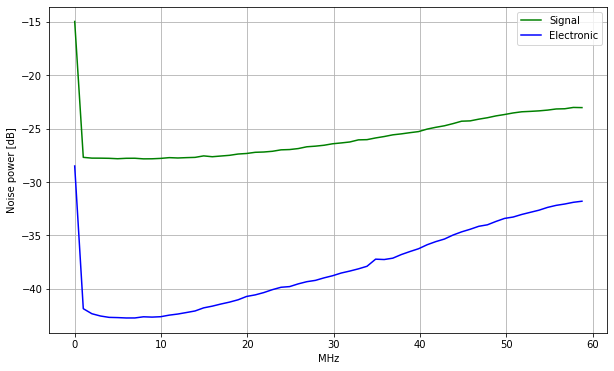

In [47]:
# Input state data
input_data_folder = "20240222/"#"input/"
#voltage_folder = '001/'#extra[extra.find('voltage') + len('voltage'): extra.find('-')]
input_extra = '1/'

input_folder = {'vac': path['vac'], '001': folder + date[v] + input_data_folder + '001/1/', '002': folder + date[v] + input_data_folder + '002/1'}

# Apply temporal mode function to a single data
#mf_homodyne, mf_vacuum, input_rho = apply_mode_function(homodyne, vacuum, input_folder = input_folder, input_plot = False)

# Mode function parameter to vary
k_med = 2*np.pi*30e6
window = 2*np.pi*20e6
points = 7
k_list = np.linspace(k_med - window, k_med + window, points)

# Apply temporal mode function to multilple data
mf_homodyne = {v: [] for v in voltages}
mf_vacuum = {v: [] for v in voltages}
input_rho = {v: [] for v in voltages}
input_data = {v: [] for v in voltages}

for v in voltages:
    for j, k in enumerate(k_list):
        homo, vac = data[v].apply_mode_function(homodyne[v], vacuum[v], homodyne_k=k)
        mf_homodyne[v].append(homo)
        mf_vacuum[v].append(vac)
        
        input_data[v].append(inputstate.inputstate(input_folder[v], n_dim, data[v].mf, input_plot = False))

        
## Coincidences
        
# SSPD time delay information
sspd_time_delay = 100e-9
window = 4e-9

# Obtain data and success rate for multiple data and varying mode function parameter
coincidence = {v: [coincidencecheck.selectdata(mf_homodyne[v][k], charlie[v], data[v].meta, window, verbose = False) for k in range(len(k_list))] for v in voltages}
sig = {v: [None for k in range(len(k_list))] for v in voltages}
success_rate = {v: [None for k in range(len(k_list))] for v in voltages}
for v in voltages:
    for k in range(len(k_list)):
        sig[v][k], success_rate[v] = coincidence[v][k].select_teleported_data()
          
# Calculate output state for multiple data and multiple time delays
runs = len(k_list)
rho = {v: np.zeros((runs, n_dim+1, n_dim+1), dtype = complex) for v in voltages}
fidelity = {v: np.zeros(runs) for v in voltages}
for v in voltages:
    for i in range(runs):
        rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v][i].input_rho, success_rate[v], n_dim, plot = False, verbose = False)

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


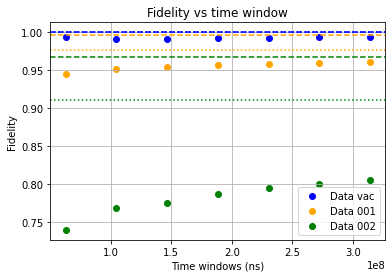

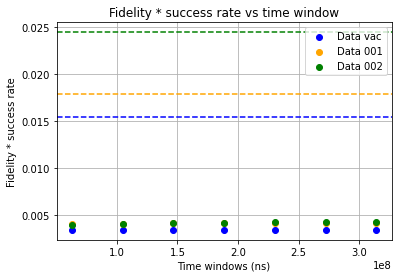

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


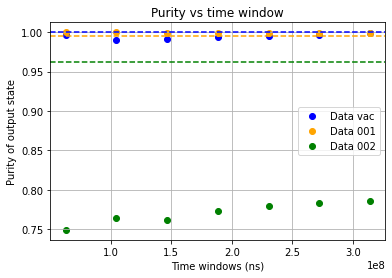

In [48]:
plot_mf_parameters(rho, input_data, fidelity, success_rate, k_list, voltages)

## Vary t

VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


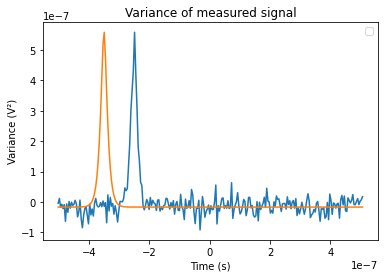

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


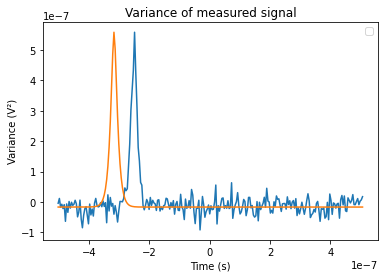

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


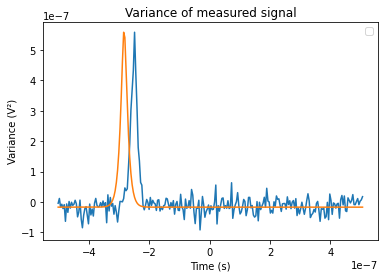

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


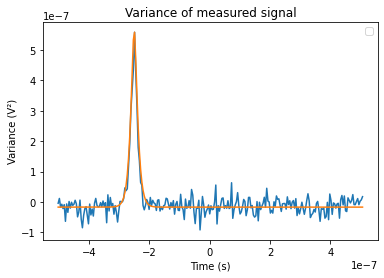

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


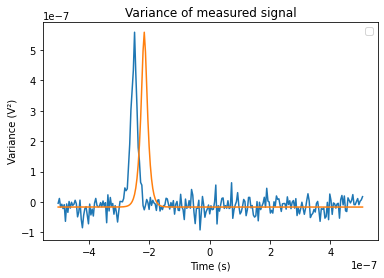

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


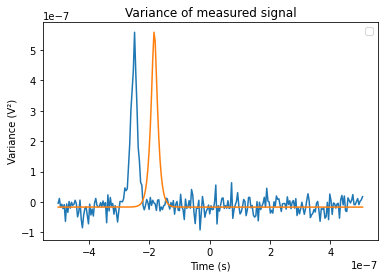

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


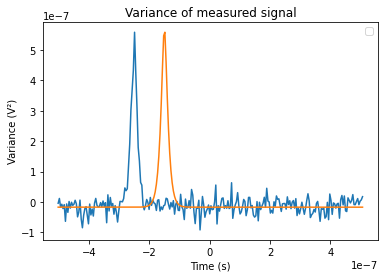

Input |alpha| = 0.00
Relay theta = 90.00°
Input state theta = 0.00°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


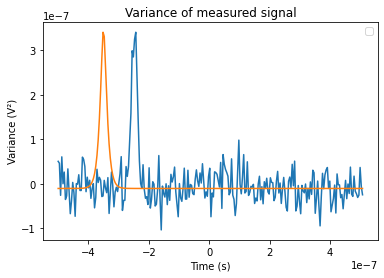

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.16073330589944773
Block 1 Input |\alpha| = 0.15760434886810992
Block 2 Input |\alpha| = 0.10207059733200179
Block 3 Input |\alpha| = 0.14954605691310974
Block 4 Input |\alpha| = 0.09461929208657759
Block 5 Input |\alpha| = 0.08934724543959313
Block 6 Input |\alpha| = 0.10865144564216629
Block 7 Input |\alpha| = 0.12026094693858203
Block 8 Input |\alpha| = 0.12049924387415141
Block 9 Input |\alpha| = 0.1364960630246772
Input |\alpha| averaged through all blocks: 0.12 (0.02)
Input angle averaged through all blocks: 83.45 (8.11)°
Input |alpha| = 0.12
Relay theta = 90.00°
Input state theta = 83.45°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


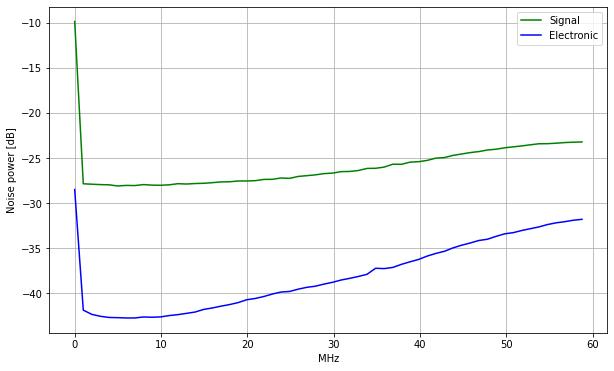

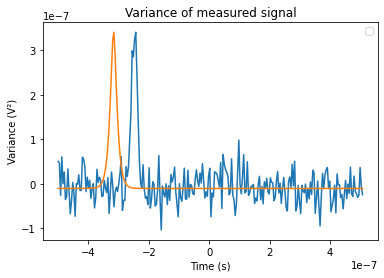

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.21664369947568143
Block 1 Input |\alpha| = 0.14532626590921602
Block 2 Input |\alpha| = 0.10240781027739844
Block 3 Input |\alpha| = 0.1338392391248004
Block 4 Input |\alpha| = 0.09436966760901278
Block 5 Input |\alpha| = 0.11007465807564207
Block 6 Input |\alpha| = 0.10455543617151984
Block 7 Input |\alpha| = 0.14016681199165495
Block 8 Input |\alpha| = 0.12851962414601234
Block 9 Input |\alpha| = 0.13830289936917575
Input |\alpha| averaged through all blocks: 0.13 (0.03)
Input angle averaged through all blocks: 83.57 (6.16)°
Input |alpha| = 0.13
Relay theta = 90.00°
Input state theta = 83.57°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


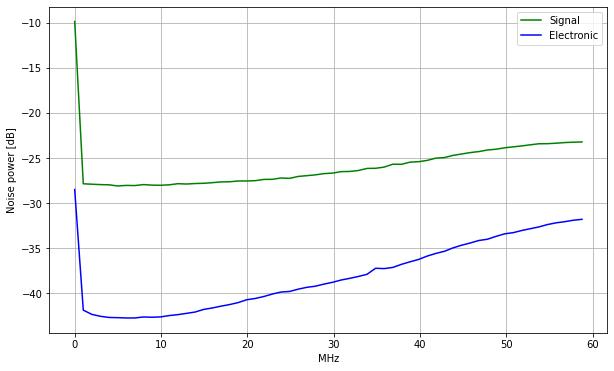

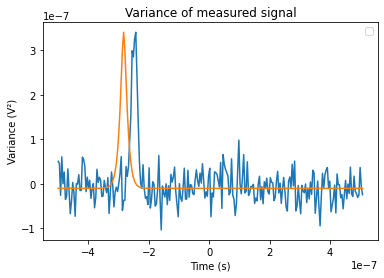

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1459242516114825
Block 1 Input |\alpha| = 0.09718751235096228
Block 2 Input |\alpha| = 0.09334373690213457
Block 3 Input |\alpha| = 0.15799727908793892
Block 4 Input |\alpha| = 0.09024745555993077
Block 5 Input |\alpha| = 0.12983771939601396
Block 6 Input |\alpha| = 0.1374081324270407
Block 7 Input |\alpha| = 0.20781226578605033
Block 8 Input |\alpha| = 0.11117551876388636
Block 9 Input |\alpha| = 0.14467078320130564
Input |\alpha| averaged through all blocks: 0.13 (0.03)
Input angle averaged through all blocks: 76.58 (16.95)°
Input |alpha| = 0.13
Relay theta = 90.00°
Input state theta = 76.58°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


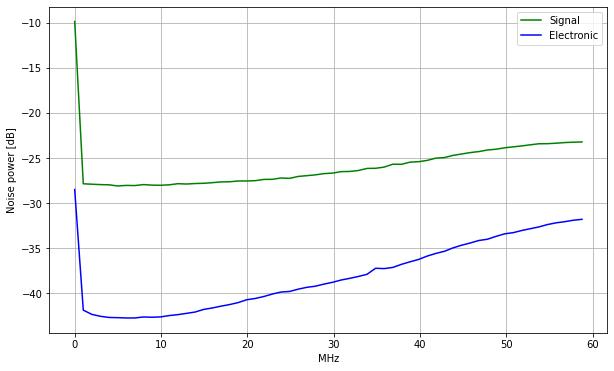

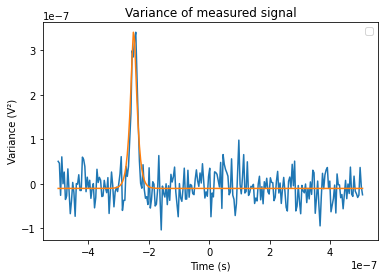

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1245956103497702
Block 1 Input |\alpha| = 0.08728945842394127
Block 2 Input |\alpha| = 0.07279673246767603
Block 3 Input |\alpha| = 0.16860820370545546
Block 4 Input |\alpha| = 0.045000865309918855
Block 5 Input |\alpha| = 0.12754755955589653
Block 6 Input |\alpha| = 0.10245029437672988
Block 7 Input |\alpha| = 0.13927873368607896
Block 8 Input |\alpha| = 0.1634270323025909
Block 9 Input |\alpha| = 0.12285609624709849
Input |\alpha| averaged through all blocks: 0.12 (0.04)
Input angle averaged through all blocks: 87.89 (17.64)°
Input |alpha| = 0.12
Relay theta = 90.00°
Input state theta = 87.89°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


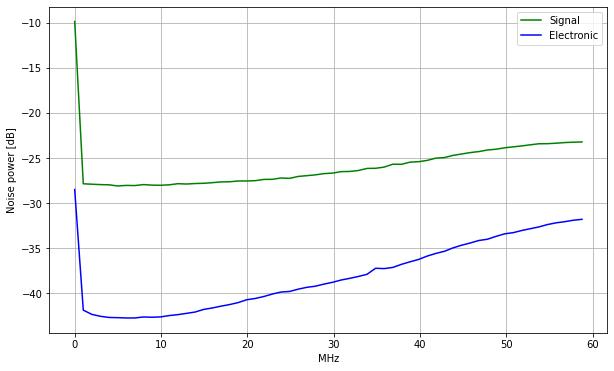

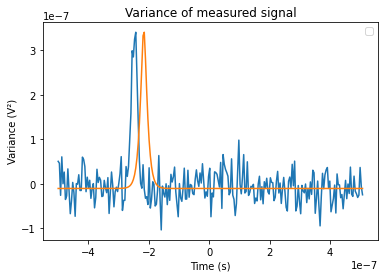

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.1545754612800419
Block 1 Input |\alpha| = 0.06308979368592862
Block 2 Input |\alpha| = 0.07955077241482171
Block 3 Input |\alpha| = 0.11733608543862346
Block 4 Input |\alpha| = 0.07614382027560344
Block 5 Input |\alpha| = 0.11942087550708873
Block 6 Input |\alpha| = 0.13597073472696142
Block 7 Input |\alpha| = 0.10746652927801985
Block 8 Input |\alpha| = 0.10142008737744523
Block 9 Input |\alpha| = 0.08791573784013464
Input |\alpha| averaged through all blocks: 0.10 (0.03)
Input angle averaged through all blocks: 97.99 (18.13)°
Input |alpha| = 0.10
Relay theta = 90.00°
Input state theta = 97.99°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


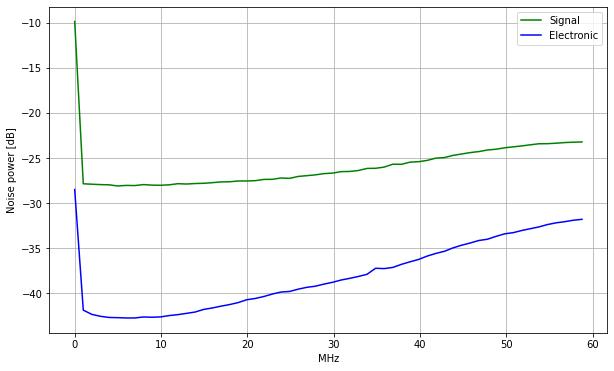

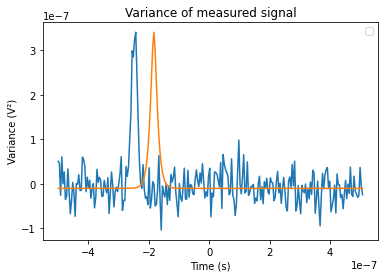

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.13452891201679462
Block 1 Input |\alpha| = 0.1252360822633966
Block 2 Input |\alpha| = 0.12172638477980241
Block 3 Input |\alpha| = 0.12624647543478393
Block 4 Input |\alpha| = 0.09529886667766574
Block 5 Input |\alpha| = 0.09973877337338191
Block 6 Input |\alpha| = 0.06479719867065133
Block 7 Input |\alpha| = 0.09915969179296089
Block 8 Input |\alpha| = 0.10779426834140654
Block 9 Input |\alpha| = 0.11177942184950898
Input |\alpha| averaged through all blocks: 0.11 (0.02)
Input angle averaged through all blocks: 88.89 (10.64)°
Input |alpha| = 0.11
Relay theta = 90.00°
Input state theta = 88.89°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


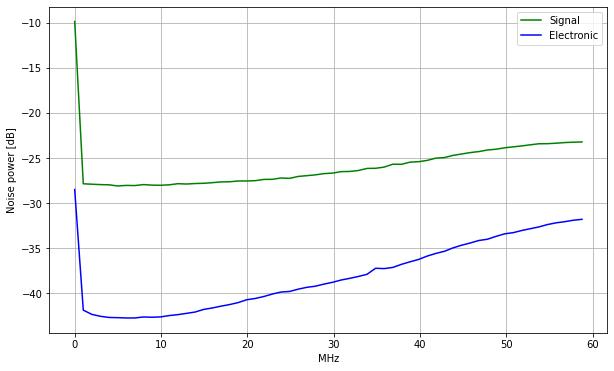

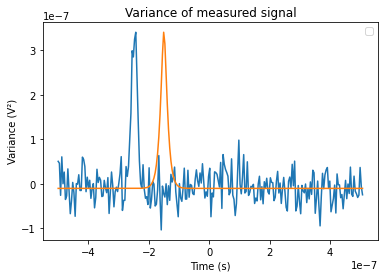

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.59 dB
0.5337 vacuum files and 0.4663 input files
0.4985 vacuum files and 0.5015 input files
Block 0 Input |\alpha| = 0.12373684095843959
Block 1 Input |\alpha| = 0.16230340300461574
Block 2 Input |\alpha| = 0.10979133134283463
Block 3 Input |\alpha| = 0.07471766253142391
Block 4 Input |\alpha| = 0.07653027557522982
Block 5 Input |\alpha| = 0.11489703093074714
Block 6 Input |\alpha| = 0.08845369468147138
Block 7 Input |\alpha| = 0.11399258109858712
Block 8 Input |\alpha| = 0.09295991328126099
Block 9 Input |\alpha| = 0.11107693255641772
Input |\alpha| averaged through all blocks: 0.11 (0.02)
Input angle averaged through all blocks: 75.91 (22.91)°
Input |alpha| = 0.11
Relay theta = 90.00°
Input state theta = 75.91°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


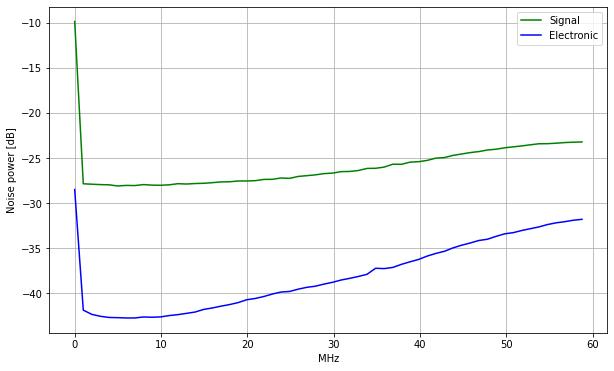

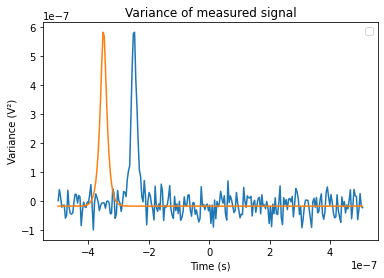

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.23524730538180555
Block 1 Input |\alpha| = 0.25595121652123975
Block 2 Input |\alpha| = 0.2542661509635746
Block 3 Input |\alpha| = 0.29173509293847977
Block 4 Input |\alpha| = 0.3015670085248279
Block 5 Input |\alpha| = 0.2786408345944308
Block 6 Input |\alpha| = 0.24485134345777324
Block 7 Input |\alpha| = 0.19688054672556612
Block 8 Input |\alpha| = 0.2327265113256663
Block 9 Input |\alpha| = 0.23586772001291176
Input |\alpha| averaged through all blocks: 0.25 (0.03)
Input angle averaged through all blocks: 152.20 (6.56)°
Input |alpha| = 0.25
Relay theta = 90.00°
Input state theta = 152.20°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


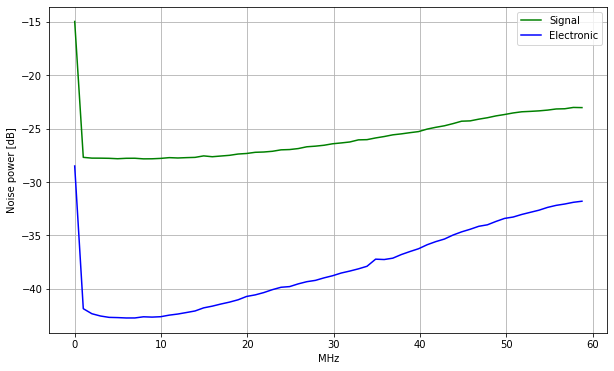

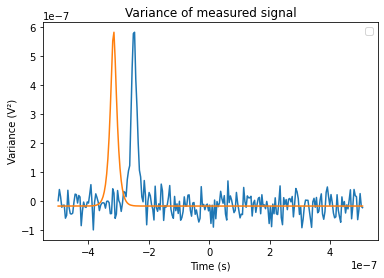

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.24336522291687515
Block 1 Input |\alpha| = 0.21113863916165668
Block 2 Input |\alpha| = 0.23429645324598777
Block 3 Input |\alpha| = 0.2681003734466133
Block 4 Input |\alpha| = 0.27613972382662777
Block 5 Input |\alpha| = 0.2958388776765803
Block 6 Input |\alpha| = 0.2524891598012531
Block 7 Input |\alpha| = 0.2500576247548485
Block 8 Input |\alpha| = 0.2353801920696623
Block 9 Input |\alpha| = 0.20481740909926835
Input |\alpha| averaged through all blocks: 0.25 (0.03)
Input angle averaged through all blocks: 157.84 (7.43)°
Input |alpha| = 0.25
Relay theta = 90.00°
Input state theta = 157.84°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


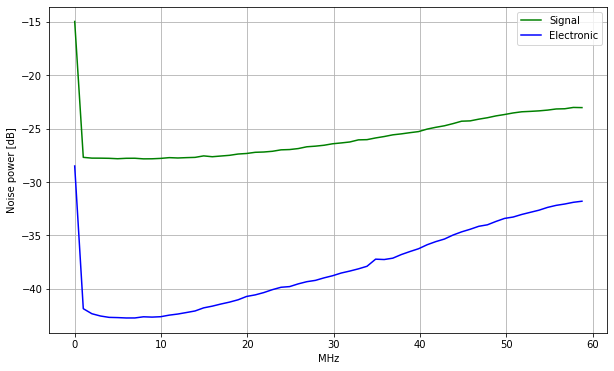

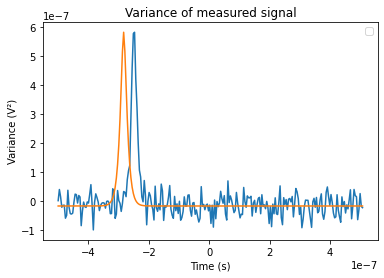

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.2090414466482227
Block 1 Input |\alpha| = 0.2565606796095764
Block 2 Input |\alpha| = 0.23988855694329575
Block 3 Input |\alpha| = 0.23401347467847974
Block 4 Input |\alpha| = 0.2517490993875536
Block 5 Input |\alpha| = 0.3121171855438115
Block 6 Input |\alpha| = 0.23818047387589383
Block 7 Input |\alpha| = 0.20864687165310136
Block 8 Input |\alpha| = 0.25013767826586686
Block 9 Input |\alpha| = 0.25321961465073684
Input |\alpha| averaged through all blocks: 0.25 (0.03)
Input angle averaged through all blocks: 159.24 (6.38)°
Input |alpha| = 0.25
Relay theta = 90.00°
Input state theta = 159.24°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


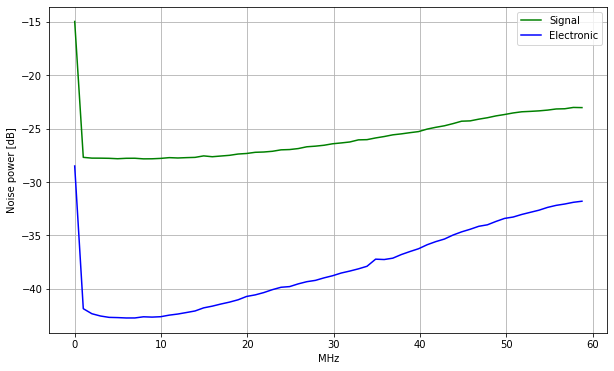

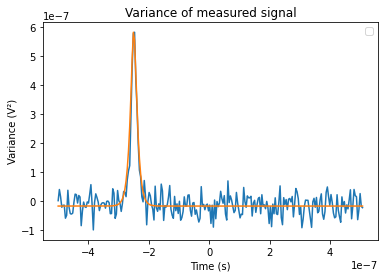

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.17933355489149827
Block 1 Input |\alpha| = 0.2549534275544496
Block 2 Input |\alpha| = 0.23504284067892467
Block 3 Input |\alpha| = 0.22242694760728812
Block 4 Input |\alpha| = 0.21529714645640805
Block 5 Input |\alpha| = 0.2026769620373596
Block 6 Input |\alpha| = 0.2019471160528192
Block 7 Input |\alpha| = 0.21892438061583927
Block 8 Input |\alpha| = 0.29117526412848815
Block 9 Input |\alpha| = 0.25267092000786795
Input |\alpha| averaged through all blocks: 0.23 (0.03)
Input angle averaged through all blocks: 159.32 (6.97)°
Input |alpha| = 0.23
Relay theta = 90.00°
Input state theta = 159.32°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


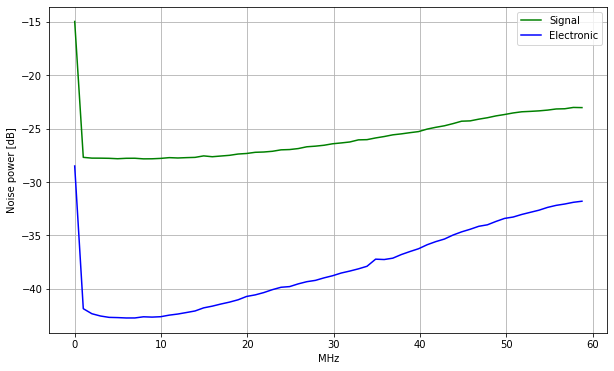

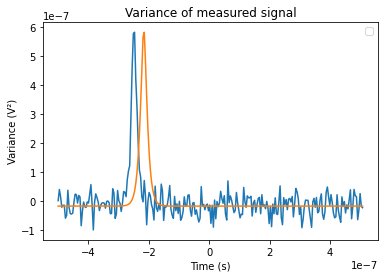

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.22470056671937116
Block 1 Input |\alpha| = 0.2890329635366398
Block 2 Input |\alpha| = 0.2393075734830209
Block 3 Input |\alpha| = 0.2590092572702421
Block 4 Input |\alpha| = 0.2320818786864949
Block 5 Input |\alpha| = 0.2291960717545858
Block 6 Input |\alpha| = 0.2544351449552261
Block 7 Input |\alpha| = 0.23588996717676042
Block 8 Input |\alpha| = 0.23559628959453616
Block 9 Input |\alpha| = 0.21632118125326114
Input |\alpha| averaged through all blocks: 0.24 (0.02)
Input angle averaged through all blocks: 154.80 (6.54)°
Input |alpha| = 0.24
Relay theta = 90.00°
Input state theta = 154.80°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


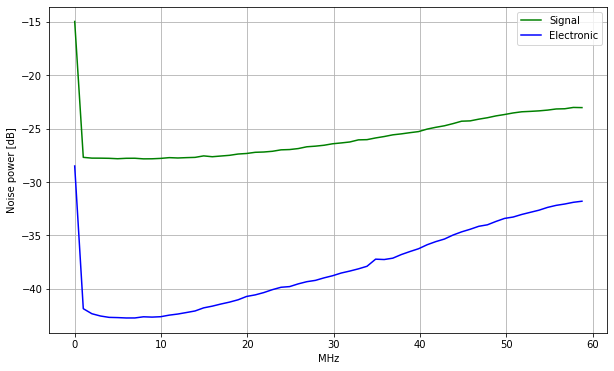

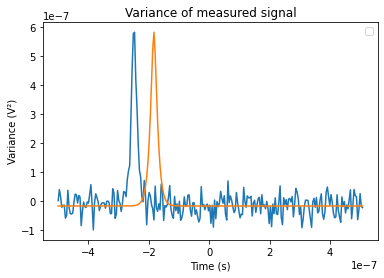

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.21041360939255974
Block 1 Input |\alpha| = 0.20301271374970425
Block 2 Input |\alpha| = 0.22537544578520718
Block 3 Input |\alpha| = 0.25341609676692883
Block 4 Input |\alpha| = 0.2516711939850076
Block 5 Input |\alpha| = 0.29099805992948663
Block 6 Input |\alpha| = 0.19597579039108037
Block 7 Input |\alpha| = 0.2960109364197277
Block 8 Input |\alpha| = 0.25590552306335734
Block 9 Input |\alpha| = 0.2061624064183355
Input |\alpha| averaged through all blocks: 0.24 (0.03)
Input angle averaged through all blocks: 156.78 (10.20)°
Input |alpha| = 0.24
Relay theta = 90.00°
Input state theta = 156.78°
PLOTS FOR INPUT STATE


VARIANCE ACROSS EACH POINT OF TELEPORTED DATA


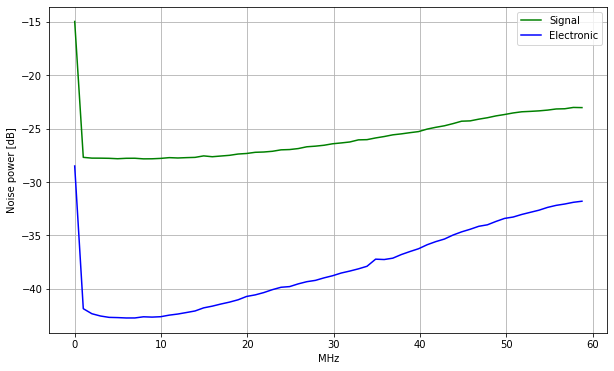

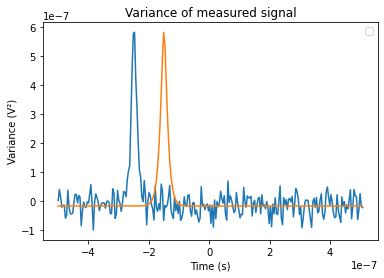

CALCULATING INPUT STATE PARAMETERS
Clearance at 10.0 MHz is 14.83 dB
0.5499 vacuum files and 0.4501 input files
0.522 vacuum files and 0.478 input files
Block 0 Input |\alpha| = 0.21222723257893256
Block 1 Input |\alpha| = 0.23180754827355937
Block 2 Input |\alpha| = 0.19915281459768747
Block 3 Input |\alpha| = 0.21615987403133152
Block 4 Input |\alpha| = 0.2117000414631293
Block 5 Input |\alpha| = 0.26198541672239284
Block 6 Input |\alpha| = 0.2032530340265549
Block 7 Input |\alpha| = 0.26102222107090955
Block 8 Input |\alpha| = 0.29563100812037424
Block 9 Input |\alpha| = 0.2095279160980797
Input |\alpha| averaged through all blocks: 0.23 (0.03)
Input angle averaged through all blocks: 156.68 (7.54)°
Input |alpha| = 0.23
Relay theta = 90.00°
Input state theta = 156.68°
PLOTS FOR INPUT STATE
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.35 %
Success rate = 0.43 %
Success rate = 0.43 

<ipython-input-19-78794f5a746e>:52: ComplexWarning: Casting complex values to real discards the imaginary part
  rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v][i].input_rho, success_rate[v], n_dim, plot = False, verbose = False)


Converged
106 runs
|alpha| = 0.04
theta = -15.27°
Converged
91 runs
|alpha| = 0.05
theta = 73.81°
Converged
130 runs
|alpha| = 0.01
theta = -54.43°
Converged
108 runs
|alpha| = 0.05
theta = -25.10°
Converged
71 runs
|alpha| = 0.04
theta = -10.95°
Converged
56 runs
|alpha| = 0.02
theta = 71.40°
Converged
161 runs
|alpha| = 0.03
theta = 51.78°
Converged
180 runs
|alpha| = 0.03
theta = -62.50°
Converged
101 runs
|alpha| = 0.04
theta = 73.32°
Converged
154 runs
|alpha| = 0.08
theta = 10.08°
Converged
65 runs
|alpha| = 0.04
theta = -44.90°
Converged
119 runs
|alpha| = 0.03
theta = 49.75°
Converged
70 runs
|alpha| = 0.04
theta = 84.23°
Converged
85 runs
|alpha| = 0.01
theta = -55.87°
Converged
136 runs
|alpha| = 0.02
theta = -88.87°
Converged
90 runs
|alpha| = 0.03
theta = -47.67°
Converged
141 runs
|alpha| = 0.07
theta = 51.09°
Converged
58 runs
|alpha| = 0.04
theta = 41.84°
Converged
86 runs
|alpha| = 0.04
theta = -18.08°
Converged
132 runs
|alpha| = 0.02
theta = 3.17°


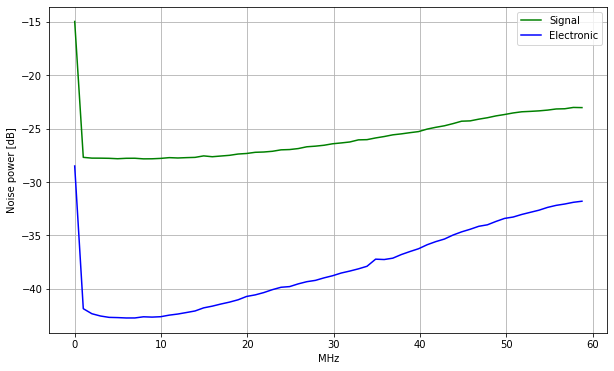

In [19]:
# Input state data
input_data_folder = "20240222/"#"input/"
#voltage_folder = '001/'#extra[extra.find('voltage') + len('voltage'): extra.find('-')]
input_extra = '1/'

input_folder = {'vac': path['vac'], '001': folder + date[v] + input_data_folder + '001/1/', '002': folder + date[v] + input_data_folder + '002/1'}

# Apply temporal mode function to a single data
#mf_homodyne, mf_vacuum, input_rho = apply_mode_function(homodyne, vacuum, input_folder = input_folder, input_plot = False)

# Mode function parameter to vary
t_med = -250e-9
window = 100e-9
points = 7
t_list = np.linspace(t_med - window, t_med + window, points)

# Apply temporal mode function to multilple data
mf_homodyne = {v: [] for v in voltages}
mf_vacuum = {v: [] for v in voltages}
input_rho = {v: [] for v in voltages}
input_data = {v: [] for v in voltages}

for v in voltages:
    for j, t in enumerate(t_list):
        homo, vac = data[v].apply_mode_function(homodyne[v], vacuum[v], homodyne_time_delay=t)
        mf_homodyne[v].append(homo)
        mf_vacuum[v].append(vac)
        
        input_data[v].append(inputstate.inputstate(input_folder[v], n_dim, data[v].mf, input_plot = False))

        
## Coincidences
        
# SSPD time delay information
sspd_time_delay = 100e-9
window = 4e-9

# Obtain data and success rate for multiple data and varying mode function parameter
coincidence = {v: [coincidencecheck.selectdata(mf_homodyne[v][t], charlie[v], data[v].meta, window, verbose = False) for t in range(len(t_list))] for v in voltages}
sig = {v: [None for t in range(len(t_list))] for v in voltages}
success_rate = {v: [None for t in range(len(t_list))] for v in voltages}
for v in voltages:
    for t in range(len(t_list)):
        sig[v][t], success_rate[v] = coincidence[v][t].select_teleported_data()
          
# Calculate output state for multiple data and multiple time delays
runs = len(t_list)
rho = {v: np.zeros((runs, n_dim+1, n_dim+1), dtype = complex) for v in voltages}
fidelity = {v: np.zeros(runs) for v in voltages}
for v in voltages:
    for i in range(runs):
        rho[v][i], fidelity[v][i] = functions.calculate_output_state(sig[v][i], input_data[v][i].input_rho, success_rate[v], n_dim, plot = False, verbose = False)

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


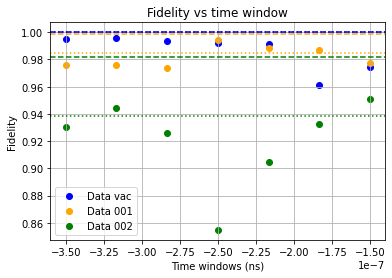

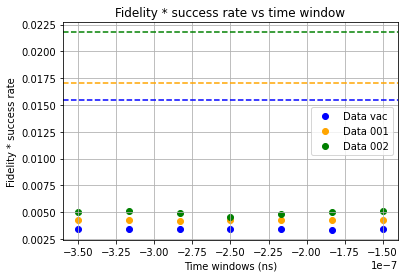

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


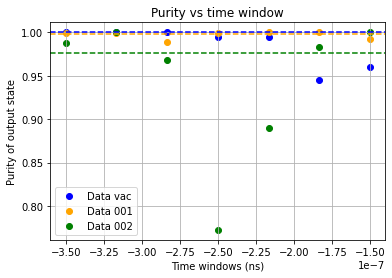

In [20]:
plot_mf_parameters(rho, input_data, fidelity, success_rate, t_list, voltages)